<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex10/Aula10_Marcus_Vinicius_Borela_de_Castro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = "Marcus Vinicius Borela de Castro"
print(f'Meu nome é {nome}')

Meu nome é Marcus Vinicius Borela de Castro


#  Exercício: Modelo de Linguagem com auto-atenção (versão após aula 10)

Este exercício é similar ao da Aula 7, mas iremos agora treinar uma rede neural *com auto-atenção* para prever a próxima palavra de um texto, data as palavras anteriores como entrada. 

Na camada de auto-atenção, não se esqueça de implementar:
- Embeddings de posição
- Projeções lineares (WQ, WK, WV, WO)
- Conexões residuais
- Camada de feed forward (2-layer MLP)



O dataset usado neste exercício (BrWaC) possui um tamanho razoável e você vai precisar rodar seus experimentos com GPU.

Alguns conselhos úteis:
- **ATENÇÃO:** o dataset é bem grande. Não dê comando de imprimí-lo.
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

# Preparação do ambiente

In [2]:
# iremos utilizar a biblioteca dos transformers para ter acesso ao tokenizador do BERT.
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importação dos pacotes

In [3]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader


In [4]:
import transformers

In [5]:
# from tqdm import tqdm_notebook
# from tqdm import tqdm

In [6]:
import time
import itertools

In [7]:
# Check which GPU we are using
!nvidia-smi

Wed Jun  8 11:54:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

## Fixando as seeds

In [8]:
def inicializa_seed(num_semente:int=123):
  """
  É recomendado reiniciar as seeds antes de inicializar o modelo, pois assim
  garantimos que os pesos vao ser sempre os mesmos.
  fontes de apoio: 
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  random.seed(num_semente)
  np.random.seed(num_semente)
  torch.manual_seed(num_semente)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  #torch.cuda.manual_seed(num_semente)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True 

In [9]:
inicializa_seed(123)

## Definindo Hiperparâmetros iniciais

In [10]:
def inicia_hparam()->dict:
  # Inicialização dos parâmetros
  hparam = {}
  hparam["num_workers_dataloader"] = 1
  hparam["device"] = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  if torch.cuda.is_available(): print(torch. cuda. get_device_name(hparam["device"]))    
  return hparam

In [11]:
hparam=inicia_hparam()

Tesla P100-PCIE-16GB


## Preparando para debug

https://zohaib.me/debugging-in-google-collab-notebook/

In [12]:
!pip install -Uqq ipdb
import ipdb
# %pdb off # desativa debug em exceção
# %pdb on  # ativa debug em exceção
# ipdb.set_trace(context=8)  para execução nesse ponto

In [13]:
# %xmode Verbose 
# %xmode Plain
# colocar %debug após ocorrer exception

In [14]:
torch.autograd.set_detect_anomaly(True)

In [15]:
import os

In [16]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [17]:
#transformers.utils.logging.set_verbosity_error()
transformers.utils.logging.set_verbosity_info()

# se usar datasets
#datasets.utils.logging.set_verbosity_error()
#datasets.utils.logging.set_verbosity_warning()


In [18]:
torch.set_printoptions(sci_mode=True) 

## Rastro (neptune.ai)

Gerado rastro da execução no Neptune (detalhes no artigo [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664))


### Importação de libraries para Rastro

In [19]:
try:
  import neptune.new as neptune  
except ImportError:
  !pip install neptune-client
  raise Exception('Stopping RUNTIME! Please run again.')


In [20]:
try:
  from torchviz import make_dot 
except ImportError:
  !pip install torchviz
  from torchviz import make_dot 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=5a5bd590187a900818682c8e2f9c01d515a0edf844c79989d4603bb74211aada
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [21]:
import getpass
import copy
import time
import re
import tempfile
import os


In [22]:
import time


### Código Rastro

Busca implementar o rastro proposto em [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664), autores Marcus Vinícius Borela de Castro e Remis Balaniuk, com o apoio da [solução Neptune](https://app.neptune.ai/)



In [23]:
def converte_optimizer_state_dict(parm_optimizer)-> dict:
  # return str(hparam['optimizer'])
  return parm_optimizer.state_dict()['param_groups'][0]

In [ ]:
def gera_tag_rastro_experiencia_treino(parm_aula:str, hparam:dict)->str:
  lista_tag = []
  lista_chaves = ['embed_dim', 'dim_feedforward', 'ind_activation_function',  'batch_size', 'learning_rate', 'weight_decay', 'amsgrad', 'decrease_factor_lr', 'max_examples', 'eval_every_steps']
  for chave in lista_chaves:
    tag = f"{chave} {hparam[chave]}"
    lista_tag.append(tag)
  return lista_tag

In [24]:
class NeptuneRastroRun():
    se_geracao_rastro = True 
    neptune_project = ""
    tag_contexto_rastro = ""
    neptune_api_token = ""

    def __init__(self, parm_params:dict,  parm_lista_tag:list = None):
      # print(f"NeptuneRastroRun.init: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_params `{parm_params} ")
      if self.__class__.se_geracao_rastro:      
        self.run_neptune = neptune.init(project=self.__class__.neptune_project, api_token=self.__class__.neptune_api_token, capture_hardware_metrics=True)
        self.run_neptune['sys/name'] = self.__class__.tag_contexto_rastro
        vparams = copy.deepcopy(parm_params)
        if "optimizer" in vparams:
          vparams["optimizer"] = converte_optimizer_state_dict(vparams["optimizer"])
        if 'criterion'  in vparams:
          vparams["criterion"] = str(vparams["criterion"])
        if 'scheduler'  in vparams:
          vparams["scheduler"] = str(type(vparams["scheduler"]))
        if 'device' in vparams:
          vparams['device'] = str(vparams["device"])
        self.device = vparams["device"]
        for tag in parm_lista_tag:
          self.run_neptune['sys/tags'].add(tag)
        self.run_neptune['parameters'] = vparams
        self.tmpDir = tempfile.mkdtemp()

    @property
    def run():
      return self.run_neptune

    @classmethod
    def ativa_geracao_rastro(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def def_contexto(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def desativa_geracao_rastro(cls):
     cls.se_geracao_rastro = False      

    @classmethod
    def retorna_status_geracao_rastro(cls):
     return cls.se_geracao_rastro      

    @classmethod
    def retorna_tag_contexto_rastro(cls):
     return cls.tag_contexto_rastro 

    @classmethod
    def inicia_contexto(cls, neptune_project, tag_contexto_rastro, neptune_api_token):
      assert '.' not in tag_contexto_rastro, "NeptuneRastroRun.init(): tag_contexto_rastro não pode possuir ponto, pois será usado para gravar nome de arquivo"      
      cls.neptune_api_token = neptune_api_token
      cls.tag_contexto_rastro = tag_contexto_rastro
      cls.neptune_project = neptune_project

    def salva_metrica(self, parm_metricas={}):
      #print(f"NeptuneRastroRun.salva_metrica: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_metricas:{parm_metricas} ")
      if self.__class__.se_geracao_rastro:
        for metrica, valor in parm_metricas.items(): 
          self.run_neptune[metrica].log(valor)
 
    def gera_grafico_modelo(self, loader_train, model):
      if self.__class__.se_geracao_rastro: 
        # efetuar um forward 
        """
        se dataloader devolver x e y:
        """
        x_, y_ = next(iter(loader_train))
        x_ = x_.to(self.device)
        outputs = model(x_)
        """
        # se dataloader devolver dict:
        dados_ = next(iter(loader_train))
        outputs = model(dados_['x'].to(self.device))
        #outputs = model(x_['input_ids'].to(self.device), x_['attention_mask'].to(self.device))
        """
        nome_arquivo = os.path.join(self.tmpDir, "modelo "+ self.__class__.tag_contexto_rastro + time.strftime("%Y-%b-%d %H:%M:%S"))
        make_dot(outputs, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render(nome_arquivo, format="png")
        self.run_neptune["parameters/model_graph"].upload(nome_arquivo+'.png')
        self.run_neptune['parameters/model'] = re.sub('<bound method Module.state_dict of ', '',str(model.state_dict))      



    def stop(self):
      if self.__class__.se_geracao_rastro:         
        self.run_neptune.stop()


### Definindo parâmetros para o rastro



In [25]:
NeptuneRastroRun.inicia_contexto('marcusborela/IA025', 'Aula 10 - Modelo de linguagem treino auto-regressivo',   getpass.getpass('Informe NEPTUNE_API_TOKEN'))
#NeptuneRastroRun.desativa_geracao_rastro()

Informe NEPTUNE_API_TOKEN··········


# Implementação do MyDataset

In [26]:
from typing import List

In [27]:
def tokenize(text: str, tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids


In [28]:
import itertools
a = [['a','b'], ['c']]
print(list(itertools.chain.from_iterable(a)))

['a', 'b', 'c']


In [29]:
class MyDataset():
    def __init__(self, texts: List[str], tokenizer, max_seq_length: int):
      """
      concatena tokenizer.cls_token_id, tokenizer.sep_token_id 
      gera sentencas x e y com max_seq_length
      como para a última posição de x não haveria label
        salva-se sentence_data com max_length + 1
        na hora de salvar
        x:sentence_data[0:max_length]
        y:sentence_data[1:max_length+1]
      """
      assert isinstance(texts,list), 'texts deve ser do tipo list'
      assert isinstance(texts[0],str), 'texts deve ser do tipo iterator of iterator of strings'
      assert isinstance(max_seq_length,int), 'max_seq_length deve ser do tipo int'
      assert max_seq_length > 3, 'max_seq_length deve ser maior do que 3'

      sentence_data = []
      sentence_length = max_seq_length + 1
      self.pad_token_id = tokenizer.pad_token_id
      self.cls_token_id = tokenizer.cls_token_id
      self.sep_token_id = tokenizer.sep_token_id
      self.qtd_sequencia = 0
      self.tensor_pad_token_id = torch.tensor(tokenizer.pad_token_id, dtype=torch.long).unsqueeze(0)
      tamanho_batch = 50
      num_batch_entrada = math.ceil(len(texts)/tamanho_batch) # inteiro acima para pegar último batch parcial de sentenças
      print(f" len(texts) {len(texts)}; tamanho_batch {tamanho_batch};  num_batch_entrada {num_batch_entrada} ")
      print(f" max_seq_length {max_seq_length}; Mas salvando sentence_length {sentence_length}")
      for ndx_batch in range(num_batch_entrada): 
        # ipdb.set_trace(context=6)
        #if ndx_batch % 100 == 0:
        #    print(F'\tInicio Mydataset ndx_batch+1: {ndx_batch+1}')
        batch_texto_numericalizado = tokenizer.batch_encode_plus(texts[ndx_batch*tamanho_batch:ndx_batch*tamanho_batch+tamanho_batch], return_attention_mask=False, return_token_type_ids = False, add_special_tokens=True).input_ids ## já retorna cls e sep

        # concatenando conforme sugerido em https://huggingface.co/course/chapter7/6?fw=pt 
        #   "A more efficient way to prepare the data is to join all the tokenized samples 
        #    in a batch with an eos_token_id token in between, and then perform the chunking 
        #    on the concatenated sequences. "
        lista_tokens_concatenadas = list(itertools.chain.from_iterable(batch_texto_numericalizado))
        num_sentencas = math.floor(len(lista_tokens_concatenadas)/sentence_length)  # eliminando a última com pads
        # if ndx_batch % 100 == 0:
        #    print(F'\t === num_sentencas:{num_sentencas} ')
        for cnt_sentenca_batch in range(num_sentencas): 
          texto_numericalizado = lista_tokens_concatenadas[cnt_sentenca_batch*sentence_length:cnt_sentenca_batch*sentence_length + sentence_length]
          sentence_data.append(texto_numericalizado)
          self.qtd_sequencia += 1
        if ndx_batch % 10 == 0:
            print(F'\t === ndx_batch+1: {ndx_batch+1}  self.qtd_sequencia: {self.qtd_sequencia}; Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      print(F'\tVou converter lista para tensor;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      self.data_tensor = torch.tensor(sentence_data).long()
      print(F'\tConvertido: lista para tensor;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      print(f"Carregado dataset com {self.qtd_sequencia} sentenças")

    def __len__(self):
      return self.qtd_sequencia

    def __getitem__(self, idx):
      if idx > self.qtd_sequencia:
        raise Exception("Tentativa de ler além do limite")
      return self.data_tensor[idx][:-1], self.data_tensor[idx][1:]

Implementado dataset abaixo com CLS em todos os começos... E sem SEP!

Mas não houve tempo para testar impacto no modelo. 

## Teste se sua implementação do MyDataset está correta

In [30]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased", do_lower_case=False)

https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpzwt06968


Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/aa6d50227b77416b26162efcf0cc9e9a702d13920840322060a2b41a44a8aff4.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
creating metadata file for /root/.cache/huggingface/transformers/aa6d50227b77416b26162efcf0cc9e9a702d13920840322060a2b41a44a8aff4.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/added_tokens.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpptfx600t


Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/added_tokens.json in cache at /root/.cache/huggingface/transformers/9188d297517828a862f4e0b0700968574ca7ad38fbc0832c409bf7a9e5576b74.5cc6e825eb228a7a5cfd27cb4d7151e97a79fb962b31aaf1813aa102e746584b
creating metadata file for /root/.cache/huggingface/transformers/9188d297517828a862f4e0b0700968574ca7ad38fbc0832c409bf7a9e5576b74.5cc6e825eb228a7a5cfd27cb4d7151e97a79fb962b31aaf1813aa102e746584b
https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpyo8delzf


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/eecc45187d085a1169eed91017d358cc0e9cbdd5dc236bcd710059dbf0a2f816.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/eecc45187d085a1169eed91017d358cc0e9cbdd5dc236bcd710059dbf0a2f816.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpx15tabcw


Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/f1a9ba41d40e8c6f5ba4988aa2f7702c3b43768183e4b82483e04f2848841ecf.a6c00251b9344c189e2419373d6033016d0cd3d87ea59f6c86069046ac81956d
creating metadata file for /root/.cache/huggingface/transformers/f1a9ba41d40e8c6f5ba4988aa2f7702c3b43768183e4b82483e04f2848841ecf.a6c00251b9344c189e2419373d6033016d0cd3d87ea59f6c86069046ac81956d
loading file https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/aa6d50227b77416b26162efcf0cc9e9a702d13920840322060a2b41a44a8aff4.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
loading file https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/added_tokens.json from cache at /root/.cache/huggingface/transformers/9188d297517828a862f4e0b0700968574ca7ad38fbc0832c409bf7a9e5576b74.5cc6e825eb228a7a5cfd

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/e716e2151985ba669e7197b64cdde2552acee146494d40ffaf0688a3f152e6ed.18a0b8b86f3ebd4c8a1d8d6199178feae9971ff5420f1d12f0ed8326ffdff716
creating metadata file for /root/.cache/huggingface/transformers/e716e2151985ba669e7197b64cdde2552acee146494d40ffaf0688a3f152e6ed.18a0b8b86f3ebd4c8a1d8d6199178feae9971ff5420f1d12f0ed8326ffdff716
loading configuration file https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e716e2151985ba669e7197b64cdde2552acee146494d40ffaf0688a3f152e6ed.18a0b8b86f3ebd4c8a1d8d6199178feae9971ff5420f1d12f0ed8326ffdff716
Model config BertConfig {
  "_name_or_path": "neuralmind/bert-base-portuguese-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hi

Dúvida
precisa?  do_lower_case=False
Resposta: não fez diferença

In [31]:
torch.tensor(tokenizer.pad_token_id, dtype=torch.long).unsqueeze(0)

tensor([0])

In [32]:
dummy_texts = ['Eu gosto de correr', 'Ela gosta muito de comer pizza pelas manhãs', 'Meu Pai, que mora em Brasília, gosta muito de correr no parque e está de dieta agora.']

In [33]:
tokens = tokenizer.batch_encode_plus(dummy_texts, return_attention_mask=False, return_token_type_ids = False, add_special_tokens=True).input_ids ## já retorna cls e sep
tokens

[[101, 3396, 10303, 125, 13239, 102],
 [101, 1660, 5971, 785, 125, 1847, 13779, 15616, 1676, 6293, 22281, 102],
 [101,
  18153,
  12075,
  117,
  179,
  9824,
  173,
  6191,
  117,
  5971,
  785,
  125,
  13239,
  202,
  5269,
  122,
  698,
  125,
  14559,
  2535,
  119,
  102]]

In [34]:
len(list(itertools.chain.from_iterable(tokens))),list(itertools.chain.from_iterable(tokens))

(40,
 [101,
  3396,
  10303,
  125,
  13239,
  102,
  101,
  1660,
  5971,
  785,
  125,
  1847,
  13779,
  15616,
  1676,
  6293,
  22281,
  102,
  101,
  18153,
  12075,
  117,
  179,
  9824,
  173,
  6191,
  117,
  5971,
  785,
  125,
  13239,
  202,
  5269,
  122,
  698,
  125,
  14559,
  2535,
  119,
  102])

In [35]:
[101, 3396, 10303, 125, 13239, 102, 101, 1660, 5971, 785, 125, 1847, 13779, 15616, 1676, 6293, 22281, 102, 101, 18153, 12075, 117, 179, 9824, 173, 6191, 117, 5971, 785, 125, 13239, 202, 5269, 122, 698, 125, 14559, 2535, 102]

[101,
 3396,
 10303,
 125,
 13239,
 102,
 101,
 1660,
 5971,
 785,
 125,
 1847,
 13779,
 15616,
 1676,
 6293,
 22281,
 102,
 101,
 18153,
 12075,
 117,
 179,
 9824,
 173,
 6191,
 117,
 5971,
 785,
 125,
 13239,
 202,
 5269,
 122,
 698,
 125,
 14559,
 2535,
 102]

In [36]:
tokenizer.decode(101), tokenizer.decode(102)

('[ C L S ]', '[ S E P ]')

In [37]:
tokenizer.batch_encode_plus(["Ela gosta muito de comer pizza mas está de dieta agora"]).input_ids

[[101,
  1660,
  5971,
  785,
  125,
  1847,
  13779,
  15616,
  449,
  698,
  125,
  14559,
  2535,
  102]]

In [38]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [39]:
tokenizer.cls_token_id, tokenizer.sep_token_id , tokenizer.pad_token_id , tokenizer.special_tokens_map 

(101,
 102,
 0,
 {'unk_token': '[UNK]',
  'sep_token': '[SEP]',
  'pad_token': '[PAD]',
  'cls_token': '[CLS]',
  'mask_token': '[MASK]'})

In [40]:
tokenizer.batch_encode_plus(tokenizer.all_special_tokens)

{'input_ids': [[101, 100, 102], [101, 102, 102], [101, 0, 102], [101, 101, 102], [101, 103, 102]], 'token_type_ids': [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], 'attention_mask': [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]]}

In [41]:
dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, max_seq_length=9)
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False)

 len(texts) 3; tamanho_batch 50;  num_batch_entrada 1 
 max_seq_length 9; Mas salvando sentence_length 10
	 === ndx_batch+1: 1  self.qtd_sequencia: 4; Momento: [2022-Jun-08 11:54:26]
	Vou converter lista para tensor;  Momento: [2022-Jun-08 11:54:26]
	Convertido: lista para tensor;  Momento: [2022-Jun-08 11:54:26]
Carregado dataset com 4 sentenças


In [42]:
assert len(dummy_dataset) == 4 # nova lógica de concatenação
print('passou no assert de tamanho do dataset')

passou no assert de tamanho do dataset


In [43]:
first_batch_input, first_batch_target = next(iter(dummy_loader))

In [44]:
first_batch_input, first_batch_target

(tensor([[  101,  3396, 10303,   125, 13239,   102,   101,  1660,  5971],
         [  125,  1847, 13779, 15616,  1676,  6293, 22281,   102,   101],
         [12075,   117,   179,  9824,   173,  6191,   117,  5971,   785],
         [13239,   202,  5269,   122,   698,   125, 14559,  2535,   119]]),
 tensor([[ 3396, 10303,   125, 13239,   102,   101,  1660,  5971,   785],
         [ 1847, 13779, 15616,  1676,  6293, 22281,   102,   101, 18153],
         [  117,   179,  9824,   173,  6191,   117,  5971,   785,   125],
         [  202,  5269,   122,   698,   125, 14559,  2535,   119,   102]]))

In [45]:
correct_first_batch_input = torch.LongTensor(
        [[  101,  3396, 10303,   125, 13239,   102,   101,  1660,  5971],
         [  125,  1847, 13779, 15616,  1676,  6293, 22281,   102,   101],
         [12075,   117,   179,  9824,   173,  6191,   117,  5971,   785],
         [13239,   202,  5269,   122,   698,   125, 14559,  2535,   119]])

correct_first_batch_target = torch.LongTensor([[ 3396, 10303,   125, 13239,   102,   101,  1660,  5971,   785],
         [ 1847, 13779, 15616,  1676,  6293, 22281,   102,   101, 18153],
         [  117,   179,  9824,   173,  6191,   117,  5971,   785,   125],
         [  202,  5269,   122,   698,   125, 14559,  2535,   119,   102]])

In [46]:
assert torch.equal(first_batch_input, correct_first_batch_input)
assert torch.equal(first_batch_target, correct_first_batch_target)

print('Passou no assert ajustado de dataset.')

Passou no assert ajustado de dataset.


# Carregamento do dataset 

Iremos usar uma pequena amostra do dataset [BrWaC](https://www.inf.ufrgs.br/pln/wiki/index.php?title=BrWaC) para treinar e avaliar nosso modelo de linguagem.

In [47]:
import io

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
#@title Seleção datasets
hparam['num_sentenca_train'] = 249800 #@param [800, 249800] {type:'raw'}
hparam['num_sentenca_valid'] = 100 # 100
hparam['num_sentenca_test'] = 100 # 100
hparam['max_seq_length'] = 50 #@param [9, 50, 100] {type:'raw'}
total_sentencas = hparam['num_sentenca_train']+hparam['num_sentenca_valid']+hparam['num_sentenca_test']
print(f"total_sentencas: {total_sentencas}")
print(f"hparam['max_seq_length']: {hparam['max_seq_length']}")


total_sentencas: 250000
hparam['max_seq_length']: 50


In [50]:
prefixo_nome_diretorio= '/content/drive/My Drive/ia025/aula10/'

infixo_nome= 'dataset_max_seq_'+ str(hparam['max_seq_length'])+'_text_'
print(prefixo_nome_diretorio + infixo_nome)

/content/drive/My Drive/ia025/aula10/dataset_max_seq_50_text_


In [51]:
#@title Boolean fields
datasets_carregados_previamente = True #@param {type:"boolean"}

print(datasets_carregados_previamente)

True


In [53]:
if datasets_carregados_previamente:
  with open(prefixo_nome_diretorio+infixo_nome+str(hparam['num_sentenca_test'])+'_test.pt','rb') as f:
    buffer = io.BytesIO(f.read())
  test_dataset = torch.load(buffer)
  with open(prefixo_nome_diretorio+infixo_nome+str(hparam['num_sentenca_valid'])+'_valid.pt','rb') as f:
    buffer = io.BytesIO(f.read())
  valid_dataset = torch.load(buffer)
  with open(prefixo_nome_diretorio+infixo_nome+str(hparam['num_sentenca_train'])+'_train.pt','rb') as f:
    buffer = io.BytesIO(f.read())
  train_dataset = torch.load(buffer)    

In [ ]:
if not datasets_carregados_previamente:
  !wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula9/sample-1gb.txt
  texts = open('sample-1gb.txt').readlines() 
  assert total_sentencas <= len(texts), f"total sentencas deve ser <= len(texts)"
  # texts = texts[:total]  

  # carga total para treino:
  # hparam['num_sentenca_train'] = total_sentencas - (hparam['num_sentenca_valid'] + hparam['num_sentenca_test'])
  # train_texts = texts[:hparam['num_sentenca_train'] ]
  # hparam['num_sentenca_train'] = len(train_texts)
  # carga parcial para treino:
  
  #ipdb.set_trace(context=6)
  


--2022-06-07 09:11:51--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula9/sample-1gb.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.253.123.128, 142.250.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1230909256 (1.1G) [text/plain]
Saving to: ‘sample-1gb.txt’

sample-1gb.txt      100%[===================>]   1.15G   182MB/s    in 6.8s    

2022-06-07 09:11:58 (173 MB/s) - ‘sample-1gb.txt’ saved [1230909256/1230909256]



In [ ]:
if not datasets_carregados_previamente:
  valid_texts = texts[-(hparam['num_sentenca_valid'] + hparam['num_sentenca_test']):-hparam['num_sentenca_test']]
  print("carregando valid_dataset")
  valid_dataset = MyDataset(texts=valid_texts, tokenizer=tokenizer, max_seq_length=hparam['max_seq_length'])
  torch.save(valid_dataset, prefixo_nome_diretorio+infixo_nome+str(hparam['num_sentenca_valid'])+'_valid.pt')



carregando valid_dataset
 len(texts) 100; tamanho_batch 50;  num_batch_entrada 2 
 max_seq_length 100; Mas salvando sentence_length 101
	 === ndx_batch+1: 1  self.qtd_sequencia: 745; Momento: [2022-Jun-07 09:12:04]
	Vou converter lista para tensor;  Momento: [2022-Jun-07 09:12:05]
	Convertido: lista para tensor;  Momento: [2022-Jun-07 09:12:05]
Carregado dataset com 1312 sentenças


In [ ]:
if not datasets_carregados_previamente:
  print("carregando test_dataset")
  test_texts = texts[-hparam['num_sentenca_test']:]  
  test_dataset = MyDataset(texts=test_texts, tokenizer=tokenizer, max_seq_length=hparam['max_seq_length'])
  torch.save(test_dataset, prefixo_nome_diretorio+infixo_nome+str(hparam['num_sentenca_test'])+'_test.pt')

carregando test_dataset
 len(texts) 100; tamanho_batch 50;  num_batch_entrada 2 
 max_seq_length 100; Mas salvando sentence_length 101
	 === ndx_batch+1: 1  self.qtd_sequencia: 392; Momento: [2022-Jun-07 09:12:07]
	Vou converter lista para tensor;  Momento: [2022-Jun-07 09:12:08]
	Convertido: lista para tensor;  Momento: [2022-Jun-07 09:12:08]
Carregado dataset com 737 sentenças


In [ ]:
if not datasets_carregados_previamente:
  assert hparam['num_sentenca_train'] <=  total_sentencas - (hparam['num_sentenca_valid'] + hparam['num_sentenca_test']), f"Dados de treino não podem conter dados de validação/teste"
  train_texts = texts[:hparam['num_sentenca_train'] ]

  print("carregando train_dataset")
  train_dataset = MyDataset(texts=train_texts, tokenizer=tokenizer, max_seq_length=hparam['max_seq_length'])
  torch.save(train_dataset, prefixo_nome_diretorio+infixo_nome+str(hparam['num_sentenca_train'])+'_train.pt')

  drive.flush_and_unmount()
  print('All changes made in this colab session should now be visible in Drive.')
  

carregando train_dataset
 len(texts) 249800; tamanho_batch 50;  num_batch_entrada 4996 
 max_seq_length 100; Mas salvando sentence_length 101
	 === ndx_batch+1: 1  self.qtd_sequencia: 616; Momento: [2022-Jun-07 09:12:28]
	 === ndx_batch+1: 11  self.qtd_sequencia: 7126; Momento: [2022-Jun-07 09:12:39]
	 === ndx_batch+1: 21  self.qtd_sequencia: 11829; Momento: [2022-Jun-07 09:12:47]
	 === ndx_batch+1: 31  self.qtd_sequencia: 17657; Momento: [2022-Jun-07 09:12:57]
	 === ndx_batch+1: 41  self.qtd_sequencia: 23394; Momento: [2022-Jun-07 09:13:06]
	 === ndx_batch+1: 51  self.qtd_sequencia: 28938; Momento: [2022-Jun-07 09:13:16]
	 === ndx_batch+1: 61  self.qtd_sequencia: 36288; Momento: [2022-Jun-07 09:13:28]
	 === ndx_batch+1: 71  self.qtd_sequencia: 43204; Momento: [2022-Jun-07 09:13:40]
	 === ndx_batch+1: 81  self.qtd_sequencia: 48500; Momento: [2022-Jun-07 09:13:49]
	 === ndx_batch+1: 91  self.qtd_sequencia: 53903; Momento: [2022-Jun-07 09:13:58]
	 === ndx_batch+1: 101  self.qtd_sequencia

In [54]:
hparam['train_size'] = len(train_dataset) 
hparam['valid_size'] = len(valid_dataset) 
hparam['test_size'] = len(test_dataset) 


print(f"training examples: {hparam['train_size']}")
print(f"valid examples: {hparam['valid_size']}")
print(f"test examples: {hparam['test_size']}")





training examples: 5486232
valid examples: 2599
test examples: 1461



max_seq_length=100, train_senteces = 249800
* training examples: 2769036
* valid examples: 1312
* test examples: 737

max_seq_length=50, train_senteces = 249800
* training examples: 5486232
* valid examples: 2599
* test examples: 1461




# Modelo Self-attention, decoder-only 
  
  Language Model trainning

## Teoria

Explicações interessantes em:

* https://jalammar.github.io/illustrated-transformer/
* https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens 

### Figuras

Fonte imagens abaixo material do curso

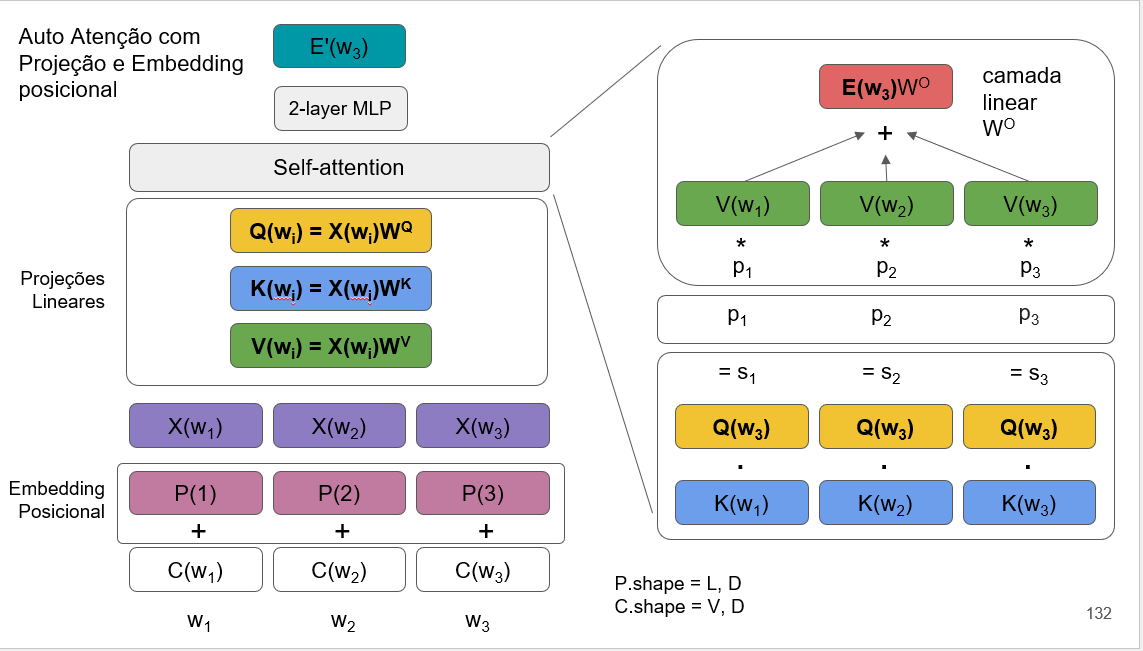

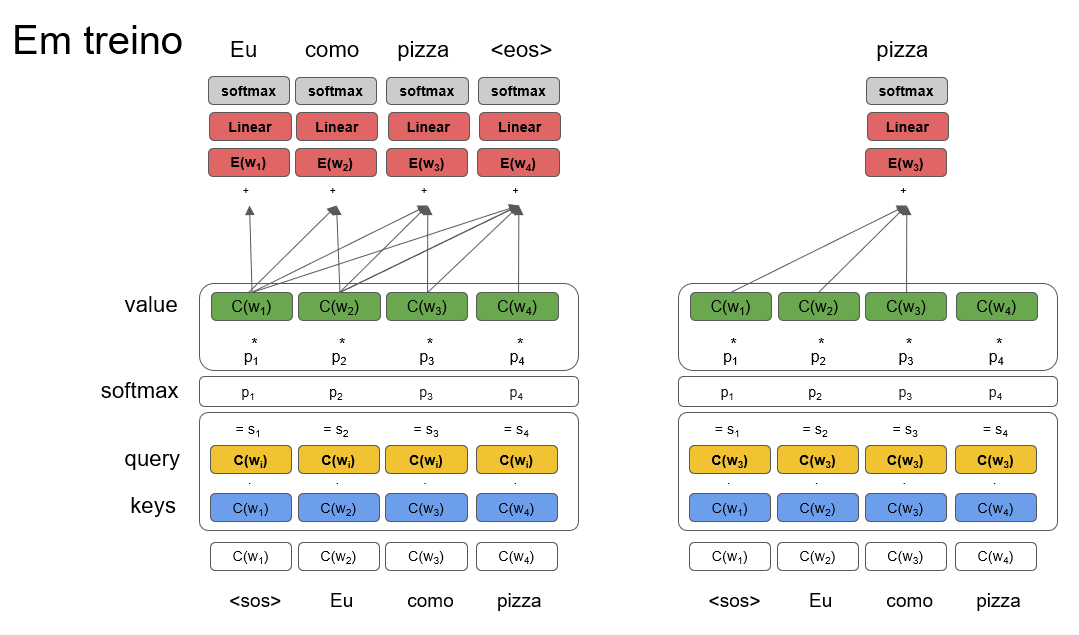



Fonte imagens abaixo: https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853#:~:text=Decoder%20Self%2DAttention&text=of%20each%20word.-,This%20is%20fed%20to%20all%20three%20parameters%2C%20Query%2C%20Key%2C,for%20each%20word%20as%20well.

End-to-end Multi-head Attention

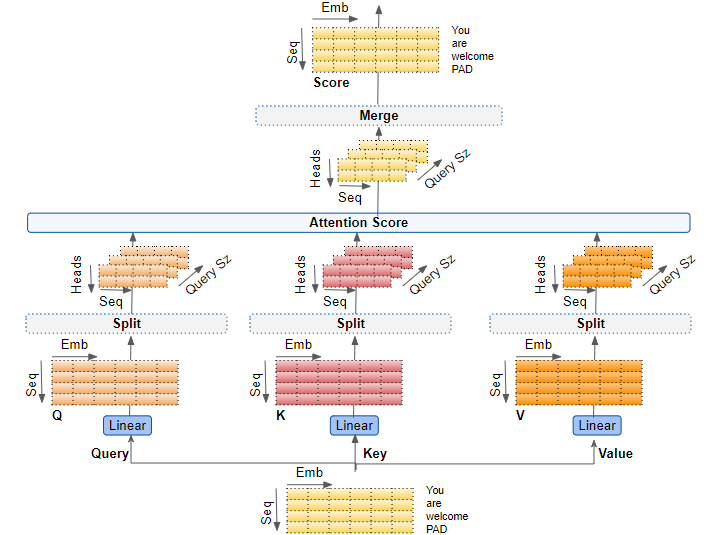

Decoder self attention

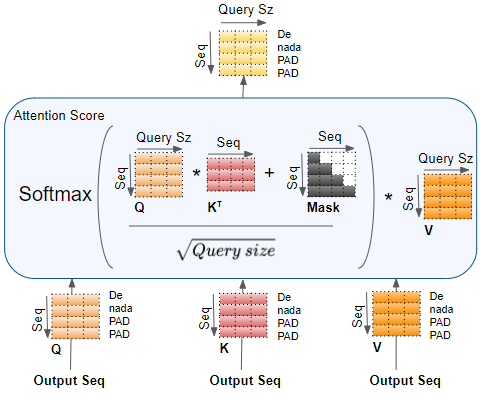

Calculando Attention 

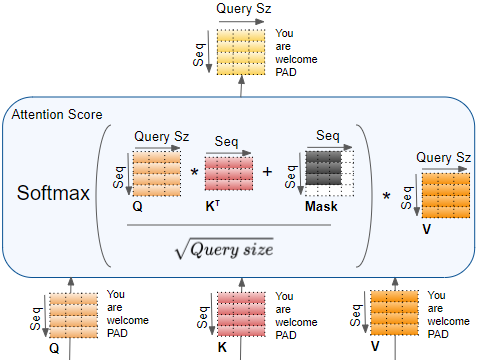

Detalhes

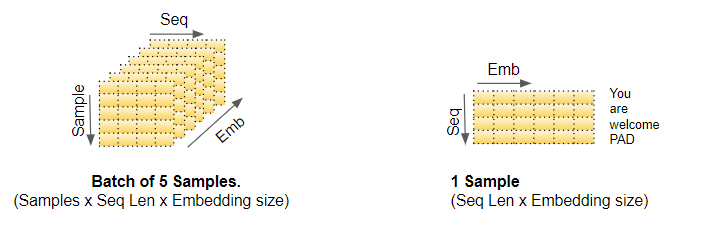

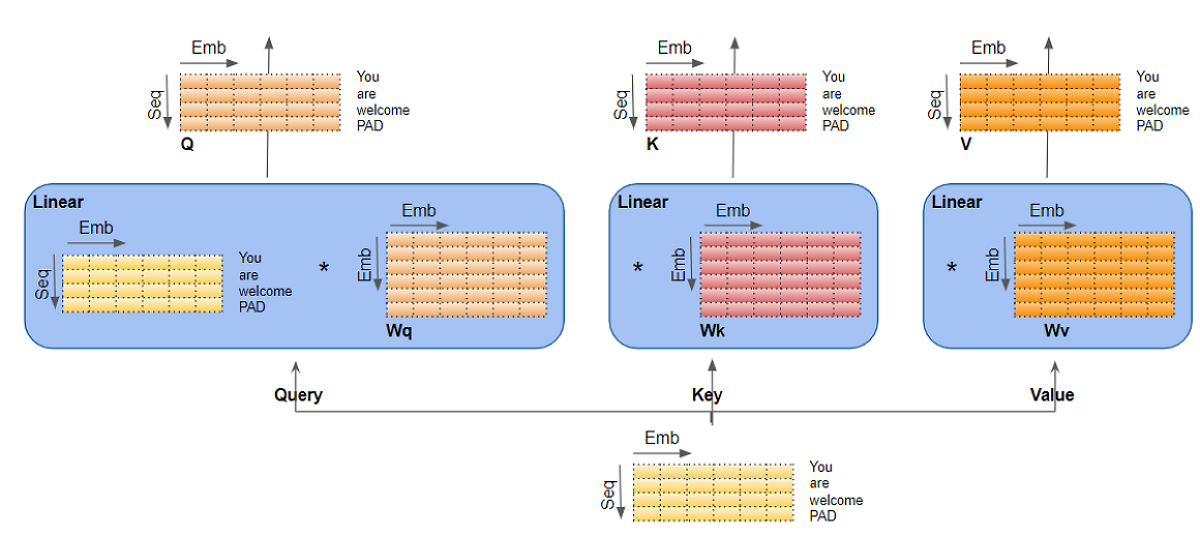

Subcamadas em uma camada

Fonte: https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch/notebook

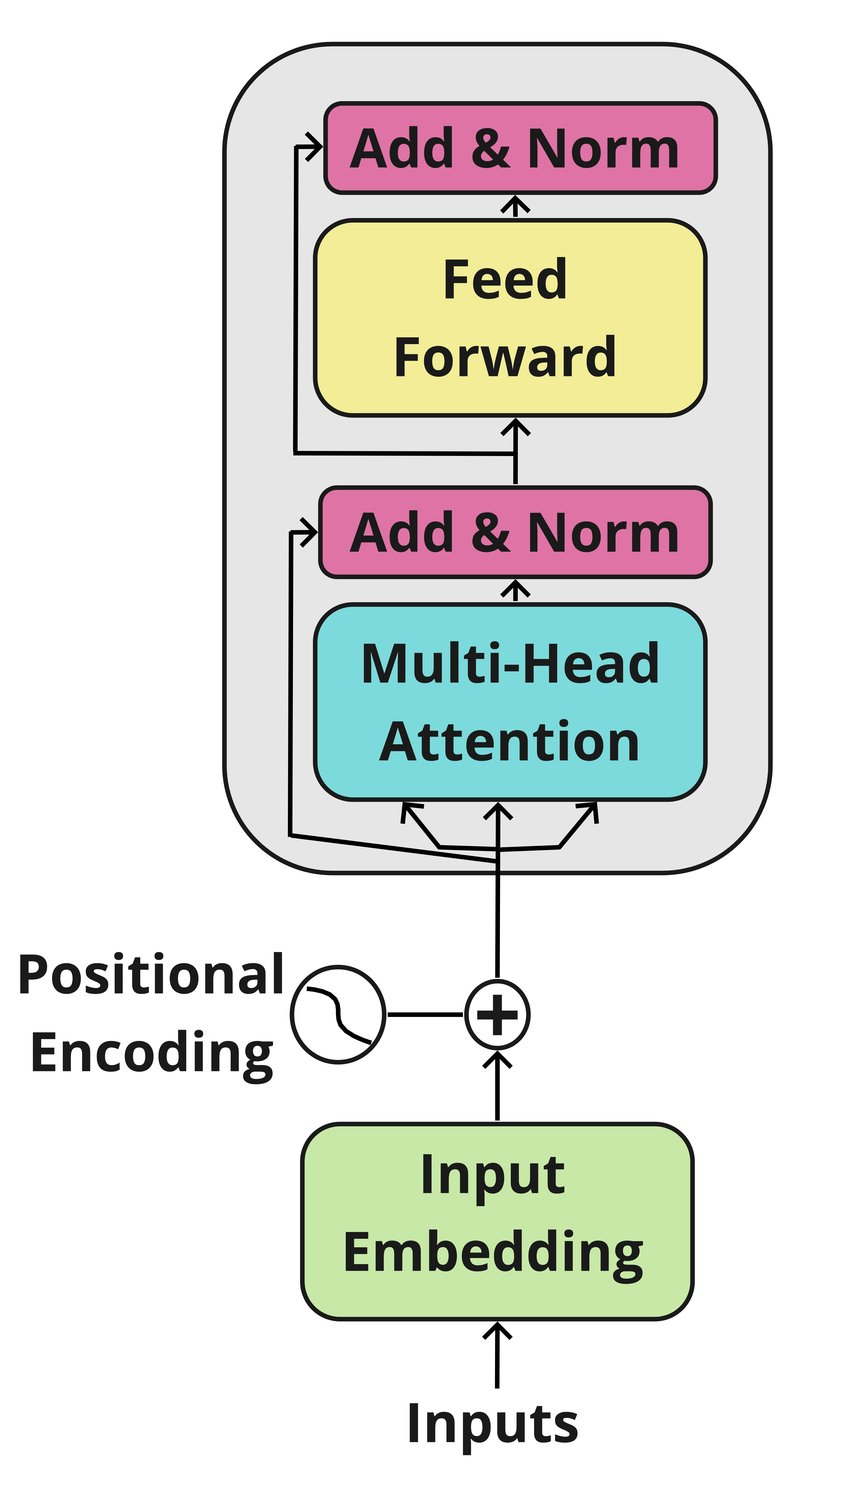

### Verificando implementação no Pytorch

**[torch.nn.TransformerDecoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html)**

Modelo tende a evoluir (próximas aulas) para essa layer

> (d_model, nhead, dim_feedforward=2048, dropout=0.1, activation=<function relu>, layer_norm_eps=1e-05, batch_first=False, norm_first=False, device=None, dtype=None)[SOURCE]

> TransformerDecoderLayer is made up of self-attn, multi-head-attn and feedforward network. This standard decoder layer is based on the paper “Attention Is All You Need”. Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in Neural Information Processing Systems, pages 6000-6010. Users may modify or implement in a different way during application.


x = torch.nn.TransformerDecoderLayer(d_model=768, nhead=1)

x

Parâmetros da função: MultiheadAttentionForwardFuncOptions(
*   int64_t embed_dim_to_check, 
*   int64_t num_heads, 
*   Tensor in_proj_weight, 
*   Tensor in_proj_bias, 
*   Tensor bias_k, 
*   Tensor bias_v, 
*   bool add_zero_attn, 
*   double dropout_p, 
*   Tensor out_proj_weight, 
*   Tensor out_proj_bias)

## Classes

In [107]:
class TransformerLayer(torch.nn.Module):


    def __init__(self, vocab_size:int, max_seq_length:int, embed_dim:int, 
                 pad_token_id: int, # n_layers: int=2,
                 dim_feedforward:int=256, 
                 ind_activation_function:str='gelu',  initializer_range:float=0.02,
                 # se_aplica_peso_posicao:bool=True,
                 prop_dropout_feedforward1:float=0.1, 
                 prop_dropout_feedforward2:float=0.1, prop_dropout_headattn:float=0.1,
                 se_bias_kvo:bool=False, 
                 # se_scale_attn_weights:bool=False,
                 verbose=False):
      """
      Implements the TransformerLayer with Self-attention and feed forward."

      Args:
          vocab_size (int): Size of the input vocabulary.
          max_seq_length (int): Size of the sequence to consider as context for prediction.
          embed_dim (int): Dimension of the embedding layer for each word in the context.
          n_layers (int): number of self-attention layers.
          dim_feedforward (int): Size of the hidden layer.
          pad_token_id (int): id of the pad token that will be ignored in the attention.
   
      Fontes de apoio:
        https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch/notebook


      Erros corrigidos que estavam no meu código (após aula 9):
        
        . tirei divisão por emb_size (seria devido se multihead e pelo dk não embed_dim)
            #divising by square root of key dimension - ag multihead implementation
            # divide by dK (num cabeças)
            #if self.se_scale_attn_weights:
            #  produto_vetorial = produto_vetorial / math.sqrt(self.embed_dim) 

        . tirei troca de posição (seria devido se multihead)
            # concatenated output
            # reshape abaixo só faz sentido para multihead, para juntar as cabeças
            # embed_sequencia_com_att = embed_sequencia_com_att.transpose(1, 2).contiguous().reshape(batch_size, seq_length, -1)  # B, L, D



      """
      # Escreva seu código aqui.
      assert vocab_size==29794, f'Para aproveitar tokenizador do BERTimbau vocab_size deve ser 768 e não {vocab_size}'      
      assert ind_activation_function in ('relu','gelu'), f'ind_activation_function deve ser um dos valores: (relu,gelu) e não {ind_activation_function}'
      assert max_seq_length in [9, 50, 100],  f'max_seq_length deve ser [9, 50, 100] (datasets pré-carregado para esse valor!) e não {max_seq_length}'      

      super().__init__()
      self.mask_triangular = torch.tril(torch.ones(max_seq_length, max_seq_length)).unsqueeze(0) 
      self.se_bias_kvo = se_bias_kvo
      self.max_seq_length = max_seq_length
      self.embed_dim = embed_dim
      self.vocab_size = vocab_size
      self.dim_feedforward = dim_feedforward
      self.verbose = verbose
      self.ind_activation_function = ind_activation_function
      self.max_seq_length = max_seq_length
      self.prop_dropout_feedforward1 = prop_dropout_feedforward1 # The dropout ratio for the feedforward
      self.prop_dropout_feedforward2 = prop_dropout_feedforward2 # The dropout ratio for the feedforward
      self.prop_dropout_headattn = prop_dropout_headattn # The dropout ratio for the attention
      self.initializer_range = initializer_range # The standard deviation of the truncated_normal_initializer for initializing all weight matrices.
      # self.se_scale_attn_weights = se_scale_attn_weights # Scale attention weights by dividing by sqrt(..
      self.pad_token_id = pad_token_id
        
      self.query_matrix = nn.Linear(self.embed_dim , self.embed_dim ,bias=False)  # 
      self.key_matrix = nn.Linear(self.embed_dim  , self.embed_dim, bias=self.se_bias_kvo)
      self.value_matrix = nn.Linear(self.embed_dim ,self.embed_dim , bias=self.se_bias_kvo)
      self.out_matrix = nn.Linear(self.embed_dim ,self.embed_dim, bias=self.se_bias_kvo) 
      self.layer1 = nn.Linear(self.embed_dim, self.dim_feedforward, bias=True)
      self.layer2 = nn.Linear(self.dim_feedforward,self.embed_dim, bias=True)

      self.norm_headattn = nn.LayerNorm(embed_dim,  eps=1e-05, elementwise_affine=True) 
      self.norm_feedforward = nn.LayerNorm(self.embed_dim,  eps=1e-05, elementwise_affine=True)
      self.dropout_headattn = nn.Dropout(prop_dropout_headattn)
      self.dropout_feedforward1 = nn.Dropout(prop_dropout_feedforward1)
      self.dropout_feedforward2 = nn.Dropout(prop_dropout_feedforward2)


      # Fonte caderno do colega Pedro Gengo
      # 1, max_seq_length, max_seq_length
      # precisa ser bool para mask_fill
      self.mask_triangular = torch.tril(torch.ones(max_seq_length, max_seq_length)).unsqueeze(0).bool().to(hparam['device'])
      self.init_weights()

    def init_weights(self):
      inicializa_seed(123)
      nn.init.uniform_(self.query_matrix.weight, -self.initializer_range, self.initializer_range)
      nn.init.uniform_(self.key_matrix.weight, -self.initializer_range, self.initializer_range)
      nn.init.uniform_(self.value_matrix.weight, -self.initializer_range, self.initializer_range)
      nn.init.uniform_(self.out_matrix.weight, -self.initializer_range, self.initializer_range)
      nn.init.uniform_(self.layer1.weight, -self.initializer_range, self.initializer_range)
      # if self.verbose: print(f"self.layer1.weight.shape {self.layer1.weight.shape}\n {self.layer1.weight}")
      nn.init.zeros_(self.layer1.bias)
      nn.init.uniform_(self.layer2.weight, -self.initializer_range, self.initializer_range)
      nn.init.zeros_(self.layer2.bias)
      # if self.verbose: print(f"self.layer2.weight.shape {self.layer2.weight.shape}\n {self.layer2.weight}")
      # nn.init.zeros_(self.layer2.bias)
      if self.se_bias_kvo:
        nn.init.zeros_(self.key_matrix.bias)
        nn.init.zeros_(self.value_matrix.bias)
        nn.init.zeros_(self.out_matrix.bias)

    def feed_forward(self, entrada):
      """
      Sequência retirada do pytorch (https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#TransformerDecoderLayer.forward)
          self.dropout3(self.linear2(self.dropout(self.activation(self.linear1(x)))))

      """
      batch_size, seq_length, embed_dim = entrada.shape[0], entrada.shape[1], entrada.shape[2]
      if self.verbose: print(f"\nTransformerLayer:  Cálculo feed_forward")
      # if self.verbose: print(f"entrada.shape: (batch_size, seq_length, seq_length) {entrada.shape}\n  {entrada}")
      # entrada = entrada.view(batch_size, seq_length * embed_dim )
      if self.verbose: print(f"[após view] entrada.shape: (batch_size, seq_length, embed_dim) {entrada.shape}\n  {entrada}")
      saida = self.layer1(entrada)
      if self.verbose: print(f"apos layer1 saida.shape: (batch_size, seq_length, dim_feedforward) {saida.shape}\n  {saida}")
      if self.ind_activation_function == 'relu':
        saida = torch.nn.functional.relu(saida)
      else:
        saida = torch.nn.functional.gelu(saida)
      if self.verbose: print(f"apos ativacao saida.shape: (batch_size, seq_length, dim_feedforward) {saida.shape}\n  {saida}")
      saida = self.dropout_feedforward1(saida)
      if self.verbose: print(f"apos dropout_feedforward1 saida.shape: (batch_size, seq_length, dim_feedforward) {saida.shape}\n  {saida}")
      saida = self.layer2(saida)
      if self.verbose: print(f"apos layer2 saida.shape: (batch_size, seq_length, embed_dim) {saida.shape}\n  {saida}")
      saida = self.dropout_feedforward2(saida)
      if self.verbose: print(f"apos dropout_feedforward2 saida.shape: (batch_size, seq_length, embed_dim) {saida.shape}\n  {saida}")
      return saida


    def auto_atencao(self, query, key, value, mask_padding):

      if self.verbose: print(f"\nTransformerLayer:  auto_atencao")

      batch_size, seq_length, embed_dim = query.shape[0], query.shape[1], query.shape[2]

      # if self.verbose: print(f"query/key/value.shape: (batch_size, seq_length, embed_dim)  {query.shape}\n  {query}")
      if self.verbose: print(f"torch.transpose(key, 1, 2).shape: (batch_size,  embed_dim, seq_length) {torch.transpose(key, 1, 2).shape}\n  {torch.transpose(key, 1, 2)}")

      # AUTO-ATENÇÃO
      if self.verbose: print(f"\nCálculo do produto vetorial: query x key")
      produto_vetorial = torch.matmul(query, key.transpose(1, 2))

      assert (batch_size, seq_length, seq_length) == produto_vetorial.shape, f"produto_vetorial tem shape { produto_vetorial.shape} e deveria ter {(batch_size, seq_length, seq_length)} "
      if self.verbose: print(f"produto_vetorial.shape: (batch_size, seq_length, seq_length) {produto_vetorial.shape}\n  {produto_vetorial}")


      # B, L -> B, 1, L -> B, L, L
      mask_padding_expanded = mask_padding[:, None, :].expand_as(produto_vetorial)
      if self.verbose: print(f":: mask_padding_expanded.shape: (batch_size, seq_length, seq_length) {mask_padding_expanded.shape}\n  {mask_padding_expanded} ")
      produto_vetorial.masked_fill_(~mask_padding_expanded, float('-inf'))  # B, L, L

      # L, L -> 1, L, L -> B, L, L
      mask_triangular_expanded = self.mask_triangular.expand_as(produto_vetorial)
      if self.verbose: print(f":: mask_triangular_expanded.shape: (batch_size, seq_length, seq_length) {mask_triangular_expanded.shape}\n  {mask_triangular_expanded} ")
      produto_vetorial.masked_fill_(~mask_triangular_expanded, float('-inf'))  # B, L, L

      if self.verbose: print(f"\nCálculo do softmax do produto vetorial (probs) ")
      probs = torch.nn.functional.softmax(produto_vetorial,dim=-1)  # shape = B, L, L

      assert (batch_size, seq_length, seq_length) == probs.shape, f"probs tem shape {probs.shape} e deveria ter {(batch_size, seq_length, seq_length)} "
      if self.verbose: print(f":: probs.shape: (batch_size, seq_length, seq_length) {probs.shape}\n  {probs} ")

      if self.verbose: print(f"\nCálculo da soma ponderada do softmax (probs) pelos embeddings (de value)  ")
      embed_sequencia_com_att = torch.matmul(probs, value)           

      assert (batch_size, seq_length, embed_dim) == embed_sequencia_com_att.shape, f"embed_sequencia_com_att tem shape (batch_size, seq_length, embed_dim) {embed_sequencia_com_att.shape} e deveria ter {(batch_size, seq_length, seq_length)} "   
      if self.verbose: print(f":: embed_sequencia_com_att.shap  (batch_size, seq_length, embed_dim): {embed_sequencia_com_att.shape}\n  {embed_sequencia_com_att} ")


      output = self.out_matrix(embed_sequencia_com_att) 
      if self.verbose: print(f"após out_matrix: (batch_size, seq_length, embed_dim)  {output.shape}\n  {output}")

      output = self.dropout_headattn(output)
      if self.verbose: print(f"após dropout_headattn: (batch_size, seq_length, embed_dim)  {output.shape}\n  {output}")


      return output


    def forward(self, query, key, value, mask_padding):
      """
      Args:
          inputs is a LongTensor of shape (batch_size, seq_length)

        batch_token_ids.shape = batch_size, seq_length

        Após embed: batch_size, seq_length, embed_dim

        batch_token_ids = stack(C(w1), C(w2), C(w3))
        # batch_size = tamanho do minibatch 
        # seq_length = comprimento da sequência 
        # embed_dim = dimensão do embeddings 
        Q = K = V = X   # batch_size,seq_length,D

        scores = matmul(Q, KT) # shape = batch_size,seq_length,seq_length
        probs = softmax(scores, dim=-1) # batch_size,seqseq_lenlen, seq_length
                E = matmul(probs, V)  # shape = batch_size,seq_length,embed_dim
        return E
      """
      if self.verbose: print(f"\nTransformerLayer:  forward")

      batch_size, seq_length, embed_dim = query.shape[0], query.shape[1], query.shape[2]

      assert seq_length == self.max_seq_length, f" seq_length deve ser = self.max_seq_length::  {seq_length} <> {self.max_seq_length}"

      # PROJEÇÕES LINEARES
      query_x = self.query_matrix(query)   
      key_x = self.key_matrix(key)       
      value_x = self.value_matrix(value)
      if self.verbose: print(f"query_x.shape: (batch_size, seq_length, embed_dim)  {query_x.shape}\n  {query_x}")
      if self.verbose: print(f"key_x.shape: (batch_size, seq_length, embed_dim)  {key_x.shape}\n  ")# {key_x}")
      if self.verbose: print(f"value_x.shape: (batch_size, seq_length, embed_dim)  {value_x.shape}\n  ")#  {value_x}")

      # AUTO-ATENÇÃO
      saida_headattn = self.auto_atencao(query_x, key_x, value_x, mask_padding)
      # if self.verbose: print(f"\n[após attn] saida_headattn.shape: (batch_size, seq_length, embed_dim)  {saida_headattn.shape}\n  {saida_headattn}[após attn] ")

      # ADD&NORM 
      saida_headattn = saida_headattn + query
      if self.verbose: print(f"após saida_headattn+=query: .shape: (batch_size, seq_length, embed_dim)  {saida_headattn.shape}\n  {saida_headattn}[após attn] ")
      saida_headattn = self.norm_headattn(saida_headattn)
      if self.verbose: print(f"após norm_headattn saida_headattn.shape: (batch_size, seq_length, embed_dim)  {saida_headattn.shape}\n  {saida_headattn}[após attn] ")




      # FEED-FORWARD
      saida_feed_forward = self.feed_forward(saida_headattn)
      # if self.verbose: print(f"após feed_forward saida_feed_forward.shape: (batch_size, seq_length, embed_dim)  {saida_feed_forward.shape}\n  {saida_feed_forward}[após attn] ")

      saida_feed_forward += saida_headattn # Residual


      logits = self.norm_feedforward(saida_feed_forward)
      if self.verbose: print(f"após norm_feedforward:  logits.shape: (batch_size, seq_length, embed_dim)  {logits.shape}\n  {logits}[após attn] ")

      logits = logits * mask_padding[:, :, None]


      return logits



In [122]:
class LanguageModel(torch.nn.Module):


    def __init__(self, vocab_size:int, max_seq_length:int, embed_dim:int, 
                 pad_token_id: int, n_layers: int=2, dim_feedforward:int=256, 
                 ind_activation_function:str='gelu',  initializer_range:float=0.02,
                 se_aplica_peso_posicao:bool=True, prop_dropout_feedforward1:float=0.1, 
                 prop_dropout_feedforward2:float=0.1, prop_dropout_headattn:float=0.1,
                 se_bias_kvo:bool=False, 
                 # se_scale_attn_weights:bool=True,
                 verbose=False):
      """
      Implements the Self-attention, decoder-only."

      Args:
          vocab_size (int): Size of the input vocabulary.
          max_seq_length (int): Size of the sequence to consider as context for prediction.
          embed_dim (int): Dimension of the embedding layer for each word in the context.
          n_layers (int): number of self-attention layers.
          dim_feedforward (int): Size of the hidden layer.
          pad_token_id (int): id of the pad token that will be ignored in the attention.
   
      Fontes de apoio:
        https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch/notebook

      """
      # Escreva seu código aqui.
      assert vocab_size==29794, f'Para aproveitar tokenizador do BERTimbau vocab_size deve ser 768 e não {vocab_size}'      
      assert ind_activation_function in ('relu','gelu'), f'ind_activation_function deve ser um dos valores: (relu,gelu) e não {ind_activation_function}'
      assert max_seq_length in [9, 50, 100],  f'max_seq_length deve ser [9, 50, 100] (datasets pré-carregado para esse valor!) e não {max_seq_length}'      

      super().__init__()
      self.max_seq_length = max_seq_length
      self.embed_dim = embed_dim
      self.vocab_size = vocab_size
      self.pad_token_id = pad_token_id
      self.n_layers = n_layers
      self.verbose = verbose
      self.se_aplica_peso_posicao = se_aplica_peso_posicao
      self.initializer_range = initializer_range # The standard deviation of the truncated_normal_initializer for initializing all weight matrices.

        

      self.embedding_layer = nn.Embedding(self.vocab_size, self.embed_dim, padding_idx=pad_token_id )       
      #       
      if self.se_aplica_peso_posicao:
        self.peso_posicao = torch.nn.Linear(self.embed_dim, self.max_seq_length, bias=False)
        # self.peso_posicao = nn.Parameter(torch.zeros(self.embed_dim, self.max_seq_length, dtype=torch.float32), requires_grad=True)  
        # if self.verbose: print(f"self.peso_posicao.shape {self.peso_posicao.shape}\n {self.peso_posicao}")

      self.layers = nn.ModuleList([TransformerLayer( \
          vocab_size, max_seq_length, embed_dim, 
                 pad_token_id, dim_feedforward, 
                 ind_activation_function, initializer_range,
                 prop_dropout_feedforward1, prop_dropout_feedforward2, prop_dropout_headattn,
                 se_bias_kvo, # se_scale_attn_weights,
                 verbose)
       for i in range(n_layers)])
      

      self.classificador_head_fc1 = nn.Linear(self.embed_dim,self.embed_dim*4, bias=True)
      
      self.norm_classificador_head = nn.LayerNorm(self.embed_dim*4,  eps=1e-05, elementwise_affine=True) 

      self.classificador_head_fc2 = nn.Linear(self.embed_dim*4,self.vocab_size, bias=False)
      self.init_weights()

    def init_weights(self):
      inicializa_seed(123)
      nn.init.uniform_(self.embedding_layer.weight, -self.initializer_range, self.initializer_range)      
      nn.init.uniform_(self.classificador_head_fc1.weight, -self.initializer_range, self.initializer_range)      
      nn.init.uniform_(self.classificador_head_fc2.weight, -self.initializer_range, self.initializer_range)      
      if self.se_aplica_peso_posicao:
        nn.init.uniform_(self.peso_posicao.weight,  -self.initializer_range, self.initializer_range) 
        # if self.verbose: print(f"self.peso_posicao.shape {self.peso_posicao.shape}\n {self.peso_posicao}")

    def forward(self, batch_token_ids):
      """
      Args:
          inputs is a LongTensor of shape (batch_size, seq_length)

        batch_token_ids.shape = batch_size, seq_length

        Após embed: batch_size, seq_length, embed_dim

        batch_token_ids = stack(C(w1), C(w2), C(w3))
        # batch_size = tamanho do minibatch 
        # seq_length = comprimento da sequência 
        # embed_dim = dimensão do embeddings 
      """
      if self.verbose: print(f"\LanguageModel:  forward")

      batch_size, seq_length = batch_token_ids.shape
      assert seq_length == self.max_seq_length, f" seq_length deve ser = self.max_seq_length::  {seq_length} <> {self.max_seq_length}"

      mask_padding = batch_token_ids != self.pad_token_id
      if self.verbose: print(f"mask_padding.shape: (batch_size, seq_length) {mask_padding.shape}\n  {mask_padding}")
      
      if self.training:
        #max_len = mask_padding.sum(1).max()
        min_len = mask_padding.sum(1).min() # dataset criado para não haver padding (dica curso transformer)
        assert self.max_seq_length==min_len, f"Não deveria haver padding self.max_len=min_len, mas {self.max_len} != {min_len}"

      # Truncamento para eliminar PADs desnecessários.
      # max_len = mask_padding.sum(1).max()
      # batch_token_ids = batch_token_ids[:, :max_len]
      # mask_padding = mask_padding[:, :max_len]

      if self.verbose: print(f"batch_token_ids.shape: (batch_size, seq_length) {batch_token_ids.shape}\n  {batch_token_ids}")
      if self.verbose: print(f"batch_size {batch_size}  seq_length {seq_length} embed_dim  {self.embed_dim}")
      assert seq_length <= self.max_seq_length, f" seq_length deve ser <= self.max_seq_length::  {seq_length} <> {self.max_seq_length}"

      x = self.embedding_layer(batch_token_ids)  
      if self.verbose: print(f"Após embedding_layer x.shape: (batch_size, seq_length, embed_dim) {x.shape}\n  {x}")
      if self.se_aplica_peso_posicao:
        # Add positional embeddings
        if self.verbose: print(f"self.peso_posicao.weight[None, :seq_length, :].shape: (batch_size, seq_length, embed_dim, embed_dim)  {self.peso_posicao.weight[None, :seq_length, :].shape}\n  {self.peso_posicao.weight[None, :seq_length, :]}")       
        x += self.peso_posicao.weight[None, :seq_length, :]
        if self.verbose: print(f"Após somar embedding+pos_embed: x.shape: (batch_size, seq_length, embed_dim)  {x.shape}\n  {x}")


      for layer in self.layers:
          x = layer(x,x,x, mask_padding)

      retorno=self.classificador_head_fc1(x)
      if self.verbose: print(f"Após classificador_head_fc1 retorno.shape: (batch_size, seq_length, 4*embed_dim) {retorno.shape}\n  {retorno}")
      retorno = self.norm_classificador_head(retorno)
      retorno = torch.nn.functional.relu(retorno)
      if self.verbose: print(f"Após classificador_head norm e relu retorno.shape: (batch_size, seq_length, 4*embed_dim) {retorno.shape}\n  {retorno}")
      retorno=self.classificador_head_fc2(retorno)
      if self.verbose: print(f"Após classificador_head_fc2 retorno.shape: (batch_size, seq_length, vocab_size) {retorno.shape}\n  {retorno}")

      return retorno



## Teste do modelo

In [57]:
!nvidia-smi

Wed Jun  8 11:58:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [123]:
hparam['vocab_size']=tokenizer.vocab_size
hparam['embed_dim']=3
hparam['dim_feedforward']=256
hparam['ind_activation_function']='gelu'
hparam['n_layers'] = 2
#documentação
hparam['num_classes']=hparam['vocab_size']
hparam['batch_size'] = 2
hparam

{'num_workers_dataloader': 0,
 'device': device(type='cuda', index=0),
 'num_sentenca_train': 249800,
 'num_sentenca_valid': 100,
 'num_sentenca_test': 100,
 'max_seq_length': 50,
 'train_size': 5486232,
 'valid_size': 2599,
 'test_size': 1461,
 'vocab_size': 29794,
 'embed_dim': 3,
 'dim_feedforward': 256,
 'ind_activation_function': 'gelu',
 'n_layers': 2,
 'num_classes': 29794,
 'batch_size': 2,
 'num_epochs': 60,
 'learning_rate': 0.0001,
 'fator_corte_loss_maximo': 1,
 'decrease_factor_lr': 1e-06,
 'weight_decay': 0.0001,
 'se_aplica_peso_posicao': True,
 'drop_last': True,
 'max_examples': 3000,
 'percentual_eval_every_steps': 0.0025,
 'eval_every_steps': 1,
 'early_stop': 10,
 'criterion': CrossEntropyLoss(),
 'num_params': 7897600,
 'amsgrad': False,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr: 0.0001
     lr: 9.999400035997841e-05
     maximize: False
     weight_decay: 0.0
 
 Parameter Group 1
     amsgr

In [124]:
sample_x, sample_y = next(iter(DataLoader(valid_dataset,batch_size=hparam['batch_size'])))
sample_x = sample_x.to(hparam['device'])
print(f"sample_y.shape: {sample_y.shape}, sample_y: {sample_y}")
print(f"sample_x.shape: {sample_x.shape}, sample_x: {sample_x}")


sample_y.shape: torch.Size([2, 50]), sample_y: tensor([[10150, 22281,   221, 21873,  5838, 18899,  1182,   529,  9035,   125,
          6139,   170,   146,  3204,   221,   939,   119,  1643,   997,   291,
           325,  5943, 14355, 22287,   118,   176,   320, 21626, 22323,   122,
           123,   117,   202,  7847,   117,   222,  2442,  4648,   117,  3983,
           706,  7569,  2854,   122, 11026,   123, 16276,  2564,   351,  1115],
        [ 7275,  3204,   221,  2201,  1379,   222,  1255,   221,  2201,   221,
          5943,   125,   230,  1589,  2701,   119,  1602, 17418, 22282,   118,
           176,   136,   959,  6825,   117,  2820, 22279,   146,  1310,  4938,
           125,   327,  2701,   117,   179,  3859, 22303,   260, 19971, 22281,
           125, 11477,   171,   939,   122,  2810,   146,   347,  4938,   170]])
sample_x.shape: torch.Size([2, 50]), sample_x: tensor([[  101, 10150, 22281,   221, 21873,  5838, 18899,  1182,   529,  9035,
           125,  6139,   170,   14

In [125]:
!nvidia-smi

Wed Jun  8 12:26:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    36W / 250W |   3253MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [126]:
hparam

{'num_workers_dataloader': 0,
 'device': device(type='cuda', index=0),
 'num_sentenca_train': 249800,
 'num_sentenca_valid': 100,
 'num_sentenca_test': 100,
 'max_seq_length': 50,
 'train_size': 5486232,
 'valid_size': 2599,
 'test_size': 1461,
 'vocab_size': 29794,
 'embed_dim': 3,
 'dim_feedforward': 256,
 'ind_activation_function': 'gelu',
 'n_layers': 2,
 'num_classes': 29794,
 'batch_size': 2,
 'num_epochs': 60,
 'learning_rate': 0.0001,
 'fator_corte_loss_maximo': 1,
 'decrease_factor_lr': 1e-06,
 'weight_decay': 0.0001,
 'se_aplica_peso_posicao': True,
 'drop_last': True,
 'max_examples': 3000,
 'percentual_eval_every_steps': 0.0025,
 'eval_every_steps': 1,
 'early_stop': 10,
 'criterion': CrossEntropyLoss(),
 'num_params': 7897600,
 'amsgrad': False,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr: 0.0001
     lr: 9.999400035997841e-05
     maximize: False
     weight_decay: 0.0
 
 Parameter Group 1
     amsgr

In [127]:
model = LanguageModel(
    vocab_size=hparam['vocab_size'],
    max_seq_length=hparam['max_seq_length'],
    embed_dim=hparam['embed_dim'],
    pad_token_id = tokenizer.pad_token_id, 
    n_layers=hparam['n_layers'],      
    dim_feedforward=hparam['dim_feedforward'],
    ind_activation_function=hparam['ind_activation_function'],
    verbose=True
).to(hparam['device'])


In [128]:
saida = model(sample_x)

\LanguageModel:  forward
mask_padding.shape: (batch_size, seq_length) torch.Size([2, 50])
  tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True]], device='cuda:0')
batch_token_ids.shape: (batch_size, seq_length) torch.Size([2, 50])
  tensor([[  101, 10150, 22281,   221, 21873,  5838, 18899,  1182,   529,  9035,
           125,  6139,   170,   146,  3204,   221

In [129]:
saida[0].max(dim=-1)


torch.return_types.max(
values=tensor([9.3339e-02, 9.1989e-02, 8.8275e-02, 9.2509e-02, 9.2027e-02, 9.1034e-02, 9.3172e-02, 9.1175e-02, 9.1442e-02,
        9.3485e-02, 8.9012e-02, 9.1392e-02, 9.3063e-02, 9.2041e-02, 8.7406e-02, 9.1948e-02, 9.3483e-02, 9.3493e-02,
        9.2797e-02, 9.2892e-02, 9.1955e-02, 9.0836e-02, 9.3361e-02, 9.1465e-02, 8.8632e-02, 9.1113e-02, 9.2118e-02,
        9.3314e-02, 9.3022e-02, 8.9053e-02, 9.3473e-02, 8.8634e-02, 8.8811e-02, 8.9272e-02, 9.2644e-02, 8.7350e-02,
        9.2776e-02, 8.9671e-02, 9.1977e-02, 9.1882e-02, 8.8675e-02, 9.1860e-02, 8.8748e-02, 9.3380e-02, 8.8338e-02,
        9.3128e-02, 8.8755e-02, 8.8131e-02, 8.8234e-02, 8.7718e-02],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([19234, 19234, 19234, 19234, 19234, 19234, 19234, 19234, 19234, 19234,
        19234, 19234, 19234, 19234, 19234, 19234, 19234, 19234, 19234, 19234,
        19234, 19234, 19234, 19234, 19234, 19234, 19234, 19234, 19234, 19234,
        19234, 19234, 19234, 

In [130]:
saida.shape

torch.Size([2, 50, 29794])

In [131]:
assert saida.shape[2] == hparam['vocab_size'], "Saída[2] deveria ser do tamanho do vocabulário"
assert saida.shape[1] == hparam['max_seq_length'], "Saída[1] deveria ser do tamanho de max_seq_length"

## Perplexidade

In [68]:
def perplexity(logits, target, ignore_token_id: int):
    """
    Computes the perplexity.

    Args:
        logits: a FloatTensor of shape (batch_size, seq_length, vocab_size)
        target: a LongTensor of shape (batch_size, seq_length)

    Returns:
        A float corresponding to the perplexity
    """
    # ipdb.set_trace(context=4) 
    # muda de torch.Size([2, 100, 29794])
    # para 
    # torch.Size([200, 29794])
    logits = logits.reshape(-1, logits.shape[-1])
    # e target de 
    # torch.Size([2, 100])
    # para
    # torch.Size([200])
    target = target.reshape(-1)
    loss = nn.functional.cross_entropy(logits, target, reduction='mean', ignore_index=ignore_token_id)

    # calculando perplexidade 
    return torch.exp(loss)  

In [69]:
my_perplexity = perplexity(logits=saida, target=sample_y.to(hparam['device']), ignore_token_id=model.pad_token_id)


print(f'correct initial perplexity: {tokenizer.vocab_size}')
print(f'my perplexity:              {int(my_perplexity)}')


correct initial perplexity: 29794
my perplexity:              29813


Entendendo o cálculo da Perplexidade

In [70]:
saida.shape

torch.Size([2, 50, 29794])

In [71]:
logits = saida.reshape(-1, saida.shape[-1])
logits.shape

torch.Size([100, 29794])

In [72]:
logits = saida.reshape(-1, saida.shape[-1])

In [73]:
target=sample_y.to(hparam['device'])

In [74]:
target.shape

torch.Size([2, 50])

In [75]:
target = target.reshape(-1)

In [76]:
target.shape

torch.Size([100])

In [77]:
loss = nn.functional.cross_entropy(logits, target, reduction='mean', ignore_index=model.pad_token_id)


In [78]:
loss

tensor(1.0303e+01, device='cuda:0', grad_fn=<NllLossBackward0>)

In [79]:

# calculando perplexidade 
torch.exp(loss)  

tensor(2.9814e+04, device='cuda:0', grad_fn=<ExpBackward0>)

In [80]:
del model


In [81]:
del saida

In [82]:
del sample_x, sample_y

# Treinamento e Validação

## Funções auxiliares 

### De geração de texto

In [139]:
def penaliza_logitos_repetidos(logits, frequencia_token_na_sentenca, 
                               val_penalizacao_frequencia:float=0.05, 
                               val_penalizacao_presenca:float=0.5):
  """
    Dicas sobre penalização em repetição

    https://beta.openai.com/docs/api-reference/engines/retrieve

    mu[j] -> mu[j] - c[j] * alpha_frequency - float(c[j] > 0) * alpha_presence

    Where:

    * mu[j] is the logits of the j-th token
    * c[j] is how often that token was sampled prior to the current position
    * float(c[j] > 0) is 1 if c[j] > 0 and 0 otherwise
    * alpha_frequency is the frequency penalty coefficient
    * alpha_presence is the presence penalty coefficient  
  
    Espera logitos na ordem das palavras

  """
  tensor_presenca = frequencia_token_na_sentenca>0
  tensor_presenca = tensor_presenca.float()

  # print(f'Em Penaliza: antes logits.sum()  {logits.sum()} ')
  logits_penalizados =  logits - (frequencia_token_na_sentenca*val_penalizacao_frequencia) - tensor_presenca*val_penalizacao_presenca
  # print(f'Em Penaliza: após logits_penalizados.sum()  {logits_penalizados.sum()} ')
  return logits_penalizados

In [140]:
def penaliza_logitos_repetidos_percentual(logits, frequencia_token_na_sentenca, 
                               percent_penalizacao_frequencia:float=0.05, 
                               percent_penalizacao_presenca:float=0.5):
  """
    Dicas sobre penalização em repetição

    https://beta.openai.com/docs/api-reference/engines/retrieve

    mu[j] -> mu[j] - c[j] * alpha_frequency - float(c[j] > 0) * alpha_presence

    Where:

    * mu[j] is the logits of the j-th token
    * c[j] is how often that token was sampled prior to the current position
    * float(c[j] > 0) is 1 if c[j] > 0 and 0 otherwise
    * alpha_frequency is the frequency penalty coefficient
    * alpha_presence is the presence penalty coefficient  
  
    Espera logitos na ordem das palavras

  """
  assert percent_penalizacao_frequencia >= 0 and percent_penalizacao_frequencia <= 1, f"percent_penalizacao_frequencia deve estar entre 0 e 1. Não pode ser {percent_penalizacao_frequencia}"
  assert percent_penalizacao_presenca >= 0 and percent_penalizacao_presenca <= 1, f"percent_penalizacao_presenca deve estar entre 0 e 1. Não pode ser {percent_penalizacao_presenca}"
  tensor_presenca = frequencia_token_na_sentenca>0
  tensor_presenca = tensor_presenca.float()

  # print(f'Em Penaliza: antes logits.sum()  {logits.sum()} ')
  logits_penalizados =  logits - (frequencia_token_na_sentenca*percent_penalizacao_frequencia*logits) - tensor_presenca*percent_penalizacao_presenca*logits
  # print(f'Em Penaliza: após logits_penalizados.sum()  {logits_penalizados.sum()} ')
  return logits_penalizados

In [141]:
def penaliza_probs_repetidos(probs, frequencia_token_na_sentenca, 
                               val_penalizacao_frequencia:float=0.05, 
                               val_penalizacao_presenca:float=0.5):
  """
    Dicas sobre penalização em repetição

    https://beta.openai.com/docs/api-reference/engines/retrieve

    mu[j] -> mu[j] - c[j] * alpha_frequency - float(c[j] > 0) * alpha_presence

    Where:

    * mu[j] is the probs of the j-th token
    * c[j] is how often that token was sampled prior to the current position
    * float(c[j] > 0) is 1 if c[j] > 0 and 0 otherwise
    * alpha_frequency is the frequency penalty coefficient
    * alpha_presence is the presence penalty coefficient  
  
    Espera logitos na ordem das palavras

  """
  tensor_presenca = frequencia_token_na_sentenca>0
  tensor_presenca = tensor_presenca.float()

  # print(f'Em Penaliza: antes logits.sum()  {logits.sum()} ')
  probs_penalizados =  probs - (frequencia_token_na_sentenca*val_penalizacao_frequencia) - tensor_presenca*val_penalizacao_presenca
  # print(f'Em Penaliza: após probs_penalizados.sum()  {probs_penalizados.sum()} ')
  return probs_penalizados

In [142]:
def gera_sequencia(model,
                   device,
                   max_output_tokens:int = 15,
                   prompt:str= "Há alguns anos, o número de rapazes e moças que",
                   lista_token_encerra_geracao = [tokenizer.pad_token_id, 
                                                  tokenizer.sep_token_id,
                                                  tokenizer.cls_token_id],
                   do_sample:bool =True,
                   temperature:float = 0.8,
                   top_p:float = 0.90,
                   top_k:int = 5,
                   percent_penalizacao_frequencia:float=0.2, 
                   percent_penalizacao_presenca:float=0.3,
                   do_repetition_penalties_include_prompt:bool=False,
                   verbose:bool=False
                   ):
  """
    Os parâmetros abaixo são usados no GPT-3
    *   temperature (float) - Lower (below 1) makes the model more confident 
        and less random. Higher values make generated text more random.
    *   top_k (int) - How many tokens it considers when generating. 0 to 
          deactivate
    *   top_p (float) - only considers tokens from the top X% of confidences
    *   do_sample (bool) - If True, randomness is introduced in selection

    temperature: mais próxima de 1, maior aleatoriedade
    https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277   

    A evoluir:
    *   beams (int) - How many tokens out should we consider
    *   avaliar impacto de tokens de continuação de palavras

  """
  max_seq_length = model.max_seq_length
  model.eval()
  assert (len(prompt) + max_output_tokens) <= max_seq_length, f"Rotina precisa ser ajustada para tratar qualquer tamanho de sentença de entrada {len(prompt)} e qualquer tamanho de max_length {max_output_tokens} que limita a soma a max_seq_length {max_seq_length}"
  dummy_texts = [prompt]
  input_ids = tokenizer.batch_encode_plus(dummy_texts,max_length=max_seq_length, 
                                          padding='max_length', return_attention_mask=False,
                                          return_token_type_ids = False, add_special_tokens=False, 
                                          return_tensors='pt').input_ids 

  ndx_ultima_palavra = torch.nonzero(input_ids[0], as_tuple =False)[-1][0].item()
  if verbose: print(f"ndx_ultima_palavra {ndx_ultima_palavra}")

  # Inicializa tensor para controle de frequência para penalização de repetições
  frequencia_token_na_sentenca = torch.zeros((hparam['vocab_size']))
  if do_repetition_penalties_include_prompt:
    for token_id in  input_ids[:, :ndx_ultima_palavra].cpu().flatten():
      frequencia_token_na_sentenca[token_id.item()] += 1

  for ndx_geracao in range(max_output_tokens):
    if verbose: print(f"Soma em frequencia_token_na_sentenca {frequencia_token_na_sentenca.sum()}")
    # encontra logitos para a sentença
    logits = model(input_ids.to(device))
    if verbose: print(f"Da sentença: logits.shape {logits.shape}")
    
    # pega logitos para da última palavra
    logits = logits[:, ndx_ultima_palavra, :].cpu().detach().flatten()
    if verbose: print(f"Da última palavra: logits {logits}")

    # penaliza logitos pela repetição e frequência
    logits = penaliza_logitos_repetidos_percentual(logits, frequencia_token_na_sentenca,
                                        percent_penalizacao_frequencia, 
                                        percent_penalizacao_presenca)
  
  
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    if verbose: print(f"sorted_logits {sorted_logits}, sorted_indices {sorted_indices} ")
    probs = torch.nn.functional.softmax(sorted_logits/temperature,dim=-1)
    if verbose: print(f"probs {probs}")
    cumulative_probs = torch.cumsum(probs, dim=-1) #.flatten()
    if verbose: print(f"cumulative_probs {cumulative_probs}")
    top_p_indices = cumulative_probs < top_p
    if verbose: print(f"top_p_indices {top_p_indices}")

    if any(top_p_indices):
      ndx_token_com_cumulative_probs = torch.where(top_p_indices == True)[0][-1].item()  # critério top_p
    else:
      ndx_token_com_cumulative_probs = 0 # o primeiro já tem probabilidade superior  
    if verbose: print(f"ndx_token_com_cumulative_probs {ndx_token_com_cumulative_probs}")

    limite_ndx = min(ndx_token_com_cumulative_probs, top_k) # atende top_p e top_k
    if verbose: print(f"limite_ndx {limite_ndx}")

    token_id_escolhida = sorted_indices[0].item()
    if limite_ndx > 0: # tem opções
      if do_sample:
        token_id_escolhida = sorted_indices[random.randrange(0,limite_ndx)].item()
    if verbose: print(f"token_id_escolhida {token_id_escolhida}")

    resultado = list(zip(tokenizer.convert_ids_to_tokens(sorted_indices[:limite_ndx+1]), 
                         sorted_indices[:limite_ndx+1],
                         probs[:limite_ndx+1]))
    if verbose: print("Poderia escolher para os critérios (top_p, top_k, temperature)")
    for token, token_id , prob in resultado:
      if token_id.item()==token_id_escolhida:
        if verbose: print(f'Escolhida {ndx_geracao}:')
      if verbose:print(f"  token: {token} token_id: {token_id.item()}\
            prob: {prob.item()} logits penalizados: {logits[token_id.item()]}")
      
    ndx_ultima_palavra += 1
    input_ids[0, ndx_ultima_palavra] = token_id_escolhida
    frequencia_token_na_sentenca[token_id_escolhida] += 1
    if token_id_escolhida in lista_token_encerra_geracao: 
      print(f"Encontrado token {token_id_escolhida} que motiva parar a geração")
      break
  
  frase_gerada = tokenizer.decode(input_ids[0], skip_special_tokens = True)
  if verbose: print(F'Frase gerada final: {frase_gerada}')
  return frase_gerada

### De treinamento

In [143]:
def validation_step(input, target, parm_model):
    logits = parm_model(input)
    logits = logits.reshape(-1, logits.shape[-1])
    target = target.reshape(-1)
    loss = nn.functional.cross_entropy(logits, target, ignore_index=parm_model.pad_token_id)
    return loss.item()


In [144]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [145]:
def add_param_weight_decay(net, l2_value, skip_list=()):
  """
    A weight decay penalty of 10−4 was used in the Brown experiments 
    and a weight decay of 10−5 was used in the APNews experiments  (not applied to bias)
    fonte: https://raberrytv.wordpress.com/2017/10/29/pytorch-weight-decay-made-easy/
  """
  decay, no_decay = [], []
  for name, param in net.named_parameters():
    # if not param.requires_grad: continue # frozen weights		            
    if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list: no_decay.append(param)
    else: decay.append(param)
  return [{'params': no_decay, 'weight_decay': 0.}, {'params': decay, 'weight_decay': l2_value}]

In [152]:
def treina_modelo (parm_model, parm_loader_train, parm_loader_valid, parm_loader_test, hparam:dict, parm_tags_rastro:list, parm_se_apenas_uma_validacao:bool=False, parm_verbose:bool = True, parm_intervalo_print = 10):
  """
  """
  rastro_neptune = NeptuneRastroRun(hparam, parm_lista_tag=parm_tags_rastro)
  try:
    path_modelo = f'{prefixo_nome_diretorio}best_model_len_{hparam["max_seq_length"]}_embed_{hparam["embed_dim"]}_inicio_treino_{time.strftime("[%Y-%b-%d %H:%M:%S]")}.pt'
    train_losses = []
    n_examples = 0
    step_avaliacao = 0
    best_perplexidade_validacao = float('inf')
    best_step = 0
    history = []
    parm_model.eval()
    with torch.no_grad():
        valid_ppl = np.exp(np.average([
            validation_step(input_tmp.to(hparam['device']), target_tmp.to(hparam['device']), parm_model)
            for input_tmp, target_tmp in parm_loader_valid]))
    metrica_rastro = {"valid/perplexidade": valid_ppl}  
    history.append(metrica_rastro)
    rastro_neptune.salva_metrica(metrica_rastro)
    print(f'hparam: {hparam}')
    print(f'Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")} Métricas iniciais em validação: {metrica_rastro} Serão treinadas {hparam["max_examples"]} amostras')

    time_inicio_treino = time.time()
    ultimo_step_treinado = 0
    se_continua_execucao = True
    parm_model.train()
    qtd_step_sem_melhor_metrica = 0
    while n_examples < hparam['max_examples'] and se_continua_execucao:
        # for qtd_param_update, (input, target) in enumerate(tqdm(parm_loader_train, desc=f"Training {100*n_examples/hparam['max_examples']:.3f}%", leave=False)):  
        for qtd_param_update, (input, target) in enumerate(parm_loader_train):  
        # for qtd_param_update in range(hparam['max_examples']):  
            # input, target = next(iter(parm_loader_train))
            ultimo_step_treinado += 1 
            logits = parm_model(input.to(hparam['device']))   


            logits = logits.reshape(-1, logits.shape[-1])
            target = target.reshape(-1).to(hparam['device'])
            loss = nn.functional.cross_entropy(logits, target, ignore_index=parm_model.pad_token_id)

            hparam['optimizer'].zero_grad()            
            loss = torch.nn.functional.cross_entropy(logits, target)
            # loss = hparam['criterion'](logits, target) * hparam['fator_corte_loss']   # copiando ideia do colega Pedro_Gengo; adicional ao weight-decay
            fator_corte_loss = max(hparam['fator_corte_loss_maximo'], n_examples/hparam['max_examples'])
            loss = hparam['criterion'](logits, target) * fator_corte_loss   # ajustando para diminuir a redução na loss quando perto do fim do treino
            loss.backward()
            hparam['optimizer'].step()
            hparam['scheduler'].step()  # DÚVIDA: melhor fazer por step treino ou por step validação?  Esse último não impactou mudança.              
            loss_batch = loss.item()/fator_corte_loss # desfazendo fator_corte_loss para não refletir na perplexidade
            train_losses.append(loss_batch) 
            n_examples += len(input)  # Increment of batch size

            if ultimo_step_treinado % hparam['eval_every_steps'] == 0:
                train_ppl = np.exp(np.average(train_losses))
                parm_model.eval()
                with torch.no_grad():
                    valid_ppl = np.exp(np.average([
                        validation_step(input_tmp.to(hparam['device']), target_tmp.to(hparam['device']), parm_model)
                        for input_tmp, target_tmp in parm_loader_valid]))

                train_losses = []

                metrica_rastro = {"train/perplexidade": train_ppl,
                                  "train/loss": loss_batch, 
                                  "train/n_examples": n_examples, 
                                  "train/learning_rate": hparam["optimizer"].param_groups[1]["lr"],
                                  "valid/perplexidade": valid_ppl}  
                history.append(metrica_rastro)
                rastro_neptune.salva_metrica(metrica_rastro)

                sufixo_msg = ""
                
                # Salvando o melhor modelo de acordo com a loss de validação
                if valid_ppl < best_perplexidade_validacao:
                    best_model_dict = parm_model.state_dict()
                    best_perplexidade_validacao = valid_ppl
                    best_step = ultimo_step_treinado
                    sufixo_msg += f" novo best valid {valid_ppl}"

                    # salva a cada vez que não houver redução seguida da métrica
                    if qtd_step_sem_melhor_metrica > 1:                    
                      torch.save(parm_model, path_modelo)    
                      sufixo_msg += f"; modelo salvo em {path_modelo}"

                    qtd_step_sem_melhor_metrica = 0
                   
                    # print('best model')
                elif hparam['early_stop'] <= (ultimo_step_treinado - best_step):
                    print(f"Parando por critério de early_stop no step {ultimo_step_treinado} sendo best_step {best_step} e ealy_stop {hparam['early_stop']}")
                    se_continua_execucao = False
                    break
                else:
                    qtd_step_sem_melhor_metrica +=1
                if parm_se_apenas_uma_validacao:
                    se_continua_execucao = False
                    break
                if parm_intervalo_print > 0:
                    if (ultimo_step_treinado)%(parm_intervalo_print*hparam['eval_every_steps']) == 0: 
                        print(f'Step: {ultimo_step_treinado} Amostras:{n_examples:d}  {100*n_examples/hparam["max_examples"]:.3f}%  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")} lr: {hparam["optimizer"].param_groups[1]["lr"]:.5e} Train loss: {loss_batch:.4f} perplexidade: {train_ppl:.4f} Validação perplexidade: {valid_ppl:.4f} {sufixo_msg}')

                parm_model.train()


            if n_examples >= hparam['max_examples']:              
                break    
            
            # apenas para teste da lógica, tratar um batch por época


    # calculando tempo gasto e médio por step
    tempo_treino = time.time() - time_inicio_treino   
    rastro_neptune.run_neptune["tempo_treino"].log(tempo_treino)
    rastro_neptune.run_neptune["tempo_treino_por_step"].log(tempo_treino/ultimo_step_treinado)
    print(f"Tempo gasto total {tempo_treino:9.5f}, steps: {ultimo_step_treinado}, tempo por step {tempo_treino/ultimo_step_treinado:9.5f}")
    # ipdb.set_trace(context=4)
    print(f'Final: Step: {ultimo_step_treinado} Amostras:{n_examples:d}  {100*n_examples/hparam["max_examples"]:.3f}%  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")} lr:{hparam["optimizer"].param_groups[1]["lr"]:.5e} Train loss: {loss_batch:.4f} Train perplexidade: {train_ppl:.4f} Validação perplexidade: {valid_ppl:.4f} ')
    rastro_neptune.run_neptune["valid/best_step"].log(best_step)


    parm_model.load_state_dict(best_model_dict)
    parm_model.to(hparam['device'])
    torch.save(parm_model, path_modelo)    
    print(f"Modelo com melhor resultado em validação (step {best_step}) salvo após treino em {path_modelo}")


    with torch.no_grad():
        test_ppl = np.exp(np.average([
            validation_step(input_tmp.to(hparam['device']), target_tmp.to(hparam['device']), parm_model)
            for input_tmp, target_tmp in parm_loader_test
        ]))


    metrica_rastro = {"test/perplexidade": test_ppl}      
    print(f" Resultado com dados de teste para modelo treinado: {metrica_rastro}")
    rastro_neptune.salva_metrica(metrica_rastro)
    rastro_neptune.gera_grafico_modelo(parm_loader_train, parm_model)    


    frase_inicio = "Praticar esportes é "
    frase_final = gera_sequencia(parm_model,
                   device=hparam['device'],
                   max_output_tokens=15,
                   prompt=frase_inicio,
                   lista_token_encerra_geracao = [tokenizer.pad_token_id, 
                                                  tokenizer.sep_token_id,
                                                  tokenizer.cls_token_id],
                   do_sample=False,
                   temperature = 0.2,
                   top_p = 0.99,
                   top_k = 10,
                   percent_penalizacao_frequencia = 0.1, 
                   percent_penalizacao_presenca = 0.3,
                   do_repetition_penalties_include_prompt=False,               
                   verbose=False
                   )
    print(f"Frase inicio: {frase_inicio}")
    print(f"Frase final gerada: {frase_final}")

  finally:
    rastro_neptune.stop()


  return {"perplexidade_test":test_ppl, "perplexidade_treino":train_ppl, "best_perplexidade_validacao":best_perplexidade_validacao,  "best_step": best_step} #, "best_model_dict": best_model_dict}

In [153]:
def ajusta_parametro_grid(hparam, combinacao_parametro, classe_modelo, se_treina_poucos_dados:bool=False):
  parametro_esperado_grid = ("dim_feedforward", "batch_size", "embed_dim",	
                             "num_epochs", "learning_rate", "ind_activation_function", "fator_corte_loss_maximo", 
                             'decrease_factor_lr', 'weight_decay', 'se_aplica_peso_posicao') #  'percent_unfreeze_embeddings') #, 'percent_unfreeze_embeddings')
  for nome_parametro in parametro_esperado_grid:
      if nome_parametro not in combinacao_parametro:
          raise NotImplementedError(f'Gride de parâmetros está incompleto, não contem {nome_parametro}')
      hparam[nome_parametro] = combinacao_parametro[nome_parametro]
  for nome_parametro in combinacao_parametro:
      if nome_parametro not in parametro_esperado_grid:
          raise NotImplementedError(f'Gride de parâmetros está com parâmetro adicional não tratado: {nome_parametro}')
      hparam[nome_parametro] = combinacao_parametro[nome_parametro]
  hparam['num_workers_dataloader'] = 0
  # hparam['decrease_factor_lr'] = 1e-8
  lambdalr = lambda qtd_param_update: 1/(1 + qtd_param_update * hparam['decrease_factor_lr'] )
  hparam['drop_last'] = True
  train_loader = DataLoader(train_dataset, batch_size=hparam['batch_size'], shuffle=True, drop_last=hparam['drop_last'], num_workers=hparam['num_workers_dataloader'])
  valid_loader = DataLoader(valid_dataset, batch_size=hparam['batch_size'], shuffle=False, drop_last=hparam['drop_last'], num_workers=hparam["num_workers_dataloader"])
  test_loader = DataLoader(test_dataset, batch_size=hparam['batch_size'], shuffle=False, drop_last=hparam['drop_last'], num_workers=hparam['num_workers_dataloader'])
  if se_treina_poucos_dados:
    train_loader = [next(iter(train_loader))] # para overfit com poucos dados (1 batch)
    hparam['max_examples'] = hparam['num_epochs'] * hparam['batch_size']  # 100_000_000 # 100_000_000
    hparam['percentual_eval_every_steps'] = 0.0025
    hparam['eval_every_steps'] = math.ceil(hparam['percentual_eval_every_steps'] * (hparam['max_examples'] / hparam['batch_size']))  # a cada percentual do total
  else:
    hparam['max_examples'] = hparam['num_epochs'] * hparam['train_size'] # 100_000_000 # 100_000_000
    hparam['percentual_eval_every_steps'] = 0.0025
    hparam['eval_every_steps'] = int(hparam['percentual_eval_every_steps'] * (hparam['max_examples'] / hparam['batch_size']))  # a cada percentual do total
  hparam['train_size'] = len(train_dataset) 
  hparam['valid_size'] = len(valid_dataset) 
  hparam['test_size'] = len(test_dataset) 
  hparam['early_stop'] = 7 * hparam['eval_every_steps']
  hparam['criterion'] = torch.nn.CrossEntropyLoss()
  inicializa_seed(123)

  model = classe_modelo(
      vocab_size=hparam['vocab_size'],
      max_seq_length=hparam['max_seq_length'],
      embed_dim=hparam['embed_dim'],
      pad_token_id = tokenizer.pad_token_id, 
      n_layers=hparam['n_layers'],      
      dim_feedforward=hparam['dim_feedforward'],
      ind_activation_function=hparam['ind_activation_function'],
      se_aplica_peso_posicao=hparam['se_aplica_peso_posicao'],
      verbose=False
  ).to(hparam['device'])
  # model = model.float()
  # print(f"model.embedding_layer.weight.requires_grad: {model.embedding_layer.weight.requires_grad}")

  hparam['num_params'] = count_parameters(model)
  print(f"Number of model parameters: {hparam['num_params']}")
  # hparam['learning_rate'] =  3e-5 # 1e-3
  # hparam['weight_decay'] = 1e-4
  params = add_param_weight_decay(model, hparam['weight_decay'])
  hparam['amsgrad']=False
  hparam['optimizer'] = torch.optim.Adam(params, lr=hparam['learning_rate'], weight_decay= hparam['weight_decay'], amsgrad=hparam['amsgrad'])
  hparam['scheduler'] = torch.optim.lr_scheduler.LambdaLR(hparam['optimizer'], lr_lambda=lambdalr, verbose=False)
  hparam['lista_tag_rastro_experiencia_treino'] =  gera_tag_rastro_experiencia_treino(parm_aula='aula7', hparam=hparam) 
  return hparam, model,train_loader,valid_loader,test_loader

In [148]:
def treina_grid(hparam, gridparam, classe_modelo, se_treina_poucos_dados:bool=False): 
  keys, values = zip(*gridparam.items())
  lista_combinacao_grid = [dict(zip(keys, v)) for v in itertools.product(*values)]  
  total_combinacao = len(lista_combinacao_grid)
  print(f"Serão {total_combinacao} experimentações")
  qtd_experimento = 1
  # for cnt_combinacao, combinacao in enumerate(tqdm(lista_combinacao_grid, desc=f"Experimento {qtd_experimento}/{total_combinacao}")):
  for cnt_combinacao, combinacao in enumerate(lista_combinacao_grid):
    print(f"\n\nNUM: {qtd_experimento}/{total_combinacao} : {combinacao} ")
    hparam, model, train_loader, valid_loader, test_loader = ajusta_parametro_grid(hparam, combinacao, classe_modelo, se_treina_poucos_dados=se_treina_poucos_dados)
    resultado = treina_modelo(model, parm_loader_train=train_loader, parm_loader_valid=valid_loader,
                          parm_loader_test=test_loader, hparam=hparam,
                          parm_tags_rastro=hparam['lista_tag_rastro_experiencia_treino'],parm_se_apenas_uma_validacao=False, 
                          parm_verbose=True, parm_intervalo_print=1)
    qtd_experimento += 1


## Experimentos de treinamento

### Testando em poucos dados (Overfit)

In [ ]:
gridparam = {  'ind_activation_function': ['gelu'], # 'relu'],
               'embed_dim': [128],
               'learning_rate': [ 1e-4],
               'num_epochs':[60], # 20 x um batch
               'fator_corte_loss_maximo': [1],
               'batch_size':[50],
               'dim_feedforward': [256],
               'decrease_factor_lr': [1e-6],
               'se_aplica_peso_posicao':[True],
               'weight_decay': [1e-4]
             }                           

In [ ]:
treina_grid(hparam, gridparam, LanguageModel,se_treina_poucos_dados=True)

Serão 1 experimentações


NUM: 1/1 : {'ind_activation_function': 'gelu', 'embed_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 60, 'fator_corte_loss_maximo': 1, 'batch_size': 50, 'dim_feedforward': 256, 'decrease_factor_lr': 1e-06, 'se_aplica_peso_posicao': True, 'weight_decay': 0.0001} 
Number of model parameters: 19405568
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-256
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 249800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'max_seq_length': 50, 'train_size': 5486232, 'valid_size': 2599, 'test_size': 1461, 'vocab_size': 29794, 'embed_dim': 128, 'dim_feedforward': 256, 'ind_activation_function': 'gelu', 'n_layers': 2, 'num_classes': 29794, 'batch_size': 

Treinado por 1 época uma nova configuração de hiperparâmetros

In [134]:
gridparam = {  'ind_activation_function': ['gelu'], # 'relu'],
               'embed_dim': [512],
               'learning_rate': [ 1e-4],
               'num_epochs':[1],
               'fator_corte_loss_maximo': [1],
               'batch_size':[100],
               'dim_feedforward': [2048], # 4x embed_dim
               'decrease_factor_lr': [1e-6],
               'se_aplica_peso_posicao':[True],
               'weight_decay': [1e-4]
             }   

In [135]:
treina_grid(hparam, gridparam, LanguageModel,se_treina_poucos_dados=False)

Serão 1 experimentações


NUM: 1/1 : {'ind_activation_function': 'gelu', 'embed_dim': 512, 'learning_rate': 0.0001, 'num_epochs': 1, 'fator_corte_loss_maximo': 1, 'batch_size': 100, 'dim_feedforward': 2048, 'decrease_factor_lr': 1e-06, 'se_aplica_peso_posicao': True, 'weight_decay': 0.0001} 
Number of model parameters: 83653632
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-257
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 249800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'max_seq_length': 50, 'train_size': 5486232, 'valid_size': 2599, 'test_size': 1461, 'vocab_size': 29794, 'embed_dim': 512, 'dim_feedforward': 2048, 'ind_activation_function': 'gelu', 'n_layers': 2, 'num_classes': 29794, 'batch_size'

NameError: ignored

Perplexidade em teste

In [ ]:
# hparam['embed_dim'] = 256
# model = torch.load("/content/drive/My Drive/ia025/aula10/best_model_len_100_embed_256_inicio_treino_[2022-Jun-07 20:59:21].pt")
# hparam['embed_dim'] = 512
# model = torch.load("/content/drive/My Drive/ia025/aula10/best_model_len_100_embed_512_inicio_treino_[2022-Jun-08 00:38:33].pt")
# hparam['embed_dim'] = 128
# model = torch.load("/content/drive/My Drive/ia025/aula10/best_model_len_50_embed_128_inicio_treino_[2022-Jun-08 12:27:36].pt")
hparam['embed_dim'] = 512
model = torch.load("/content/drive/My Drive/ia025/aula10/best_model_len_50_embed_512_inicio_treino_[2022-Jun-08 12:42:35].pt")


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=hparam['batch_size'], shuffle=False, num_workers=hparam['num_workers_dataloader'])

In [ ]:
with torch.no_grad():
    test_ppl = np.exp(np.average([
        validation_step(input_tmp.to(hparam['device']), target_tmp.to(hparam['device']), model)
        for input_tmp, target_tmp in test_loader
    ]))


print(f"test/perplexidade {test_ppl}")

test/perplexidade 76.16409172995672


Treinando 3 épocas uma nova configuração de hiperparâmetros

In [157]:
gridparam = {  'ind_activation_function': ['gelu'], # 'relu'],
               'embed_dim': [1024],
               'learning_rate': [ 1e-4],
               'num_epochs':[3],
               'fator_corte_loss_maximo': [1],
               'batch_size':[200],
               'dim_feedforward': [4096], # 4x embed_dim
               'decrease_factor_lr': [1e-6],
               'se_aplica_peso_posicao':[True],
               'weight_decay': [1e-4]
             }   

In [ ]:
treina_grid(hparam, gridparam, LanguageModel,se_treina_poucos_dados=False)

Serão 1 experimentações


NUM: 1/1 : {'ind_activation_function': 'gelu', 'embed_dim': 1024, 'learning_rate': 0.0001, 'num_epochs': 3, 'fator_corte_loss_maximo': 1, 'batch_size': 200, 'dim_feedforward': 4096, 'decrease_factor_lr': 1e-06, 'se_aplica_peso_posicao': True, 'weight_decay': 0.0001} 
Number of model parameters: 181987328
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-261
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
hparam: {'num_workers_dataloader': 0, 'device': device(type='cuda', index=0), 'num_sentenca_train': 249800, 'num_sentenca_valid': 100, 'num_sentenca_test': 100, 'max_seq_length': 50, 'train_size': 5486232, 'valid_size': 2599, 'test_size': 1461, 'vocab_size': 29794, 'embed_dim': 1024, 'dim_feedforward': 4096, 'ind_activation_function': 'gelu', 'n_layers': 2, 'num_classes': 29794, 'batch_si

# Teste de geração de texto

In [149]:
# hparam['embed_dim'] = 128
# model = torch.load("/content/drive/My Drive/ia025/aula10/best_model_len_50_embed_128_inicio_treino_[2022-Jun-08 12:27:36].pt")
hparam['embed_dim'] = 512
model = torch.load("/content/drive/My Drive/ia025/aula10/best_model_len_50_embed_512_inicio_treino_[2022-Jun-08 12:42:35].pt")


In [150]:
frase_final = gera_sequencia(model,
                   device=hparam['device'],
                   max_output_tokens=20,
                   prompt="Praticar esportes é",
                   lista_token_encerra_geracao = [tokenizer.pad_token_id, 
                                                  tokenizer.sep_token_id,
                                                  tokenizer.cls_token_id],
                   do_sample=True,
                   temperature = 0.2,
                   top_p = 0.99,
                   top_k = 10,
                   percent_penalizacao_frequencia = 0.1, 
                   percent_penalizacao_presenca = 0.3,
                   do_repetition_penalties_include_prompt=False,               
                   verbose=False
                   )
frase_final

'Praticar esportes é uma das mais importantes atrações do Festival de Cannes. O evento acontece no dia 15, em São Paulo'

"Praticar esportes é"

**Modelo 1** embed_dim=512, max_seq_len=50
* [rastro aqui](https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-257)
* model = torch.load("/content/drive/My Drive/ia025/aula10/best_model_len_50_embed_512_inicio_treino_[2022-Jun-08 12:42:35].pt")
* perplexidade: 107,49 (1) 

Praticar esportes é **uma das melhores opções de jogos, mas é um dos mais importantes da atualidade. A equipe do Se**

* perplexidade: 96,7 (1) 

Praticar esportes é **uma das mais importantes atrações do Festival de Cannes. O evento acontece no dia 15, em São Paulo**



**Modelo 2** embed_dim=1024, max_seq_len=50
* [rastro aqui](https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-261)

(em treino)



**Modelo 3** embed_dim=1024, max_seq_len=100
* [rastro aqui](https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-258)

(em treino)




```
# Código que implementei para gerar frase final:

frase_final = gera_sequencia(model,
                   device=hparam['device'],
                   max_output_tokens=20,
                   prompt="Praticar esportes é",
                   lista_token_encerra_geracao = [tokenizer.pad_token_id, 
                                                  tokenizer.sep_token_id,
                                                  tokenizer.cls_token_id],
                   do_sample=True,
                   temperature = 0.2,
                   top_p = 0.99,
                   top_k = 10,
                   percent_penalizacao_frequencia = 0.1, 
                   percent_penalizacao_presenca = 0.3,
                   do_repetition_penalties_include_prompt=False,               
                   verbose=False
                   )
```
(1) Em validacao pois um erro de mudança de nome de variável impediu usar dados de teste


In [ ]:
raise Exception("Execução abaixo deve ser contextualizada")

# Rascunho 

# Utilitárias - outras

Para saber num_workes que faz a diferença

Fonte: https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/44?page=3

In [ ]:
for num_workers in range(0, 9, 1):
    start = time.time()
    loader = DataLoader(valid_dataset, batch_size=1024, shuffle=True, drop_last=True, num_workers=num_workers)
    for epoch in range(1, 4):
        for qtd_param_update, (input, target) in enumerate(loader):        
            pass
    end = time.time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

Finish with:0.02363729476928711 second, num_workers=0
Finish with:0.7012560367584229 second, num_workers=1
Finish with:1.0205585956573486 second, num_workers=2
Finish with:1.4124412536621094 second, num_workers=3
Finish with:1.7632222175598145 second, num_workers=4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:2.193779230117798 second, num_workers=5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:2.552090644836426 second, num_workers=6


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:3.050504684448242 second, num_workers=7


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finish with:3.4122939109802246 second, num_workers=8


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 9 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Exception ignored in: <function _releaseLock at 0x7efd42673830>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: ignored

# Choosing Sequence Length

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

KeyboardInterrupt: ignored

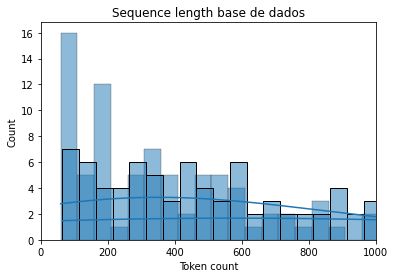

In [ ]:
if not datasets_carregados_previamente: #dados carregados
  for dados in (test_texts, valid_texts, train_texts):
    tokens = tokenizer.batch_encode_plus(dados, return_attention_mask=False, return_token_type_ids = False).input_ids
    token_lens = [len(x) for x in tokens]
    sns.histplot(token_lens, stat='count', binwidth=50, kde=True)
    plt.xlim([0, 1000])
    plt.xlabel('Token count')
    plt.title(f'Sequence length base de dados')